In [12]:
library(dplyr)
library(ggplot2)
library(FigR)
library(SummarizedExperiment)
library(GenomicRanges)
# library(BSgenome.Mmusculus.UCSC.mm10)
library(doParallel)
library(Seurat)
library(Signac)
library(FNN)
setwd('/data/bio_data/zhangzhongjin/data')

Loading required package: Matrix

Warning message:
“package ‘Matrix’ was built under R version 4.3.3”
Loading required package: SummarizedExperiment

Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.3.2”
Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.3.3”
Loading required package: matrixStats

Warning message:
“package ‘matrixStats’ was built under R version 4.3.3”

Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    c

# cistopic

* cisTopic是一个用于从单细胞表观基因组学数据同时识别顺式调控主题和细胞状态的R包
cisTopic包括四个主要步骤: (1)生成一个二进制可及性矩阵作为LDA的输入;(2) LDA和模型选择;(3)利用LDA中的主题细胞分布进行细胞状态识别，(4)探索区域主题分布。

In [1]:
library(FigR)
library(Matrix)
library(cisTopic)
library(Seurat)
library(Signac)
library(dplyr)
library(FNN)
library(GenomicRanges)

Loading required package: Matrix

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats,

In [ ]:
### scCAT_skin cistopic###
#skin.fib <- readRDS('/hwfssz5/ST_SUPERCELLS/P21Z10200N0090/caipengfei/workspace/temp/scCAT/Skin_fibroblast.rds')
# 提取atac counts并修改格式
DefaultAssay(skin.fib) <- 'ATAC'
counts=skin.fib@assays$ATAC@counts
peak_names_processed = lapply(rownames(counts), function(item){
  items = unlist(strsplit(item, '-'))
  return(paste0(items[1], ":", items[2], "-", items[3]))
})
rownames(counts)=peak_names_processed
# 创建cistopic格式并计算topic
cisTopicObject <- createcisTopicObject(counts, is.acc = 0.001)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic=c(2:15, 20, 25, 35, 40, 45, 50), seed=123, nCores=6, addModels=FALSE)
# Selection of the best topic
par(mfrow=c(3,3))
cisTopicObject <- selectModel(cisTopicObject, type='maximum')
cisTopicObject <- selectModel(cisTopicObject, type='perplexity')
cisTopicObject <- selectModel(cisTopicObject, type='derivative')
# 提取best topic的信息
cell_topic = cisTopicObject@selected.model$document_expects
cell_topic = as.data.frame(cell_topic)
#write.csv(cell_topic, file = '/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/celline/DORCs/Mcortex_topic_C4.csv', quote = F)
#saveRDS(cisTopicObject, file='/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/celline/DORCs/cisTopic_LDA_C4cortex.Rds')

In [2]:
fib.DC <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/scCAT/Mskin_fib_DC.rds')
# 提取atac counts并修改格式
DefaultAssay(fib.DC) <- 'ATAC'
counts=fib.DC@assays$ATAC@counts
peak_names_processed = lapply(rownames(counts), function(item){
  items = unlist(strsplit(item, '-'))
  return(paste0(items[1], ":", items[2], "-", items[3]))
})
rownames(counts)=peak_names_processed
# 创建cistopic格式并计算topic
cisTopicObject <- createcisTopicObject(counts, is.acc = 0.001)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic=c(2:15, 20, 25, 35, 40, 45, 50), seed=123, nCores=6, addModels=FALSE)
# Selection of the best topic
par(mfrow=c(3,3))
cisTopicObject <- selectModel(cisTopicObject, type='maximum')
cisTopicObject <- selectModel(cisTopicObject, type='perplexity')
cisTopicObject <- selectModel(cisTopicObject, type='derivative')
# 提取best topic的信息
cell_topic = cisTopicObject@selected.model$document_expects
cell_topic = as.data.frame(cell_topic)
# write.csv(cell_topic, file = '/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/celline/DORCs/Mcortex_topic.csv', quote = F)
#saveRDS(cisTopicObject, file='/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/celline/DORCs/cisTopic_LDA_C4cortex.Rds')

[1] "Exporting data..."
[1] "Run models..."


ERROR: Error in unserialize(node$con): error reading from connection


In [ ]:
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic=c(5:15,20,30), seed=123, nCores=6, addModels=FALSE)

---

# mouse skin （DORCs） 

In [1]:
library(FigR)
library(ComplexHeatmap)
library(scCustomize)
library(JASPAR2020)
library(Signac)
library(Seurat)
library(TFBSTools)
# library(BSgenome.Mmusculus.UCSC.mm10)
library(patchwork)
library(cowplot)
set.seed(1234)

Loading required package: Matrix

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats,

* peak-gene link  DORCs:(n≥5, link nums)
* DORC calling (score ≥ 2)
* 

In [3]:
skin.fib <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/03_MouseSkin/fibroblast/Mskin_fib_proce.rds')

---
peak-gene links

In [3]:
# FigR results
cisCorr = read.csv('/jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/caipengfei/workspace/multimodal/scCAT/Mouse_skin/joint/FigR/cisCorr.csv',row.names = 1)
cisCorr.filt <- cisCorr %>% filter(pvalZ <= 0.05)
options(repr.plot.width=6, repr.plot.height=5)
dorcGenes <- dorcJPlot(dorcTab = cisCorr.filt, cutoff = 5, labelTop = 10, cleanLabels=TRUE, returnGeneList = TRUE, force=20)

In [30]:
cisCorr = read.csv('/jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/caipengfei/workspace/multimodal/scCAT/Mouse_skin/joint/FigR/cisCorr.csv',row.names = 1)

In [34]:
cisCorr[cisCorr$Gene=='Ar',]

Peak   PeakRanges             Gene rObs        pvalZ      
89197 173546 chrX:98148614-98149042 Ar   0.008985087 0.075055726
89198 173547 chrX:98149860-98150550 Ar   0.013397447 0.082828890
89199 173548 chrX:98150804-98151653 Ar   0.030689090 0.001338365

---
DORCs calling

In [4]:
cisCorr.filt

Peak   PeakRanges               Gene          rObs       pvalZ       
1      63    chr1:4785132-4786324     Lypla1        0.01748660 9.098763e-03
2      66    chr1:4825953-4826290     Lypla1        0.01602811 2.508462e-02
3     129    chr1:7126068-7126281     Pcmtd1        0.01320089 1.925913e-02
4     157    chr1:9545972-9546352     Adhfe1        0.01246510 3.688410e-02
5     158    chr1:9548032-9548291     Adhfe1        0.01828741 3.316449e-03
6     159    chr1:9554213-9554664     Adhfe1        0.02031050 1.153772e-03
7     160    chr1:9564313-9565482     Adhfe1        0.04468884 3.454441e-09
8     162    chr1:9579675-9580008     Adhfe1        0.03268334 1.521463e-06
9     175    chr1:9747439-9748863     1700034P13Rik 0.03389277 6.723278e-08
10    179    chr1:9792517-9793124     1700034P13Rik 0.02462812 5.535222e-05
11    177    chr1:9772870-9773746     Sgk3          0.01574638 4.687438e-02
12    182    chr1:9805200-9806104     Sgk3          0.01834771 1.742914e-02
13    247    chr1:10955267-10955699   Prex2         0.02479016 4.412329e-02
14    248    chr1:10967392-10967605   Prex2         0.02189567 4.261445e-02
15    249    chr1:10993050-10994172   Prex2         0.01954896 1.478750e-02
16    261    chr1:11451902-11452112   A830018L16Rik 0.02747534 8.771391e-04
17    309    chr1:12691887-12693206   Sulf1         0.06412542 2.970853e-02
18    312    chr1:12711306-12711609   Sulf1         0.01041040 4.623136e-02
19    315    chr1:12715325-12715820   Sulf1         0.07168741 1.498837e-02
20    317    chr1:12734348-12734893   Sulf1         0.03229114 2.232433e-02
21    402    chr1:13639400-13640006   Xkr9          0.02667573 2.301716e-04
22    404    chr1:13647937-13648277   Xkr9          0.02865374 3.700169e-03
23    406    chr1:13682901-13683368   Xkr9          0.01947792 1.870641e-02
24    407    chr1:13684141-13684752   Xkr9          0.01535419 2.835763e-02
25    408    chr1:13698880-13699098   Xkr9          0.02961201 2.309740e-05
26    482    chr1:15312056-15312441   Kcnb2         0.02063057 7.738975e-03
27    516    chr1:16127629-16127877   Rdh10         0.02378880 3.148917e-04
28    548    chr1:16617368-16618110   Tmem70        0.01570203 3.854272e-02
29    552    chr1:16656389-16657726   Tmem70        0.01921517 4.155050e-02
30    556    chr1:16687874-16689167   Ly96          0.02337215 8.713280e-04
⋮     ⋮      ⋮                        ⋮             ⋮          ⋮           
41379 174758 chrX:161890940-161891183 Nhs           0.01986382 2.875962e-03
41380 174759 chrX:161908455-161909464 Nhs           0.02360812 1.564421e-02
41381 174806 chrX:162521243-162522527 Reps2         0.04727237 3.304049e-02
41382 174813 chrX:162735078-162736737 Gm15201       0.02643304 4.665414e-04
41383 174818 chrX:162873804-162874070 Syap1         0.02752940 4.767649e-04
41384 174830 chrX:163582547-163583303 Grpr          0.02494029 1.874795e-04
41385 174842 chrX:163982076-163982499 Zrsr2         0.01474357 2.143844e-02
41386 174844 chrX:164013353-164013736 Car5b         0.01457288 3.510568e-02
41387 174847 chrX:164075861-164076864 Siah1b        0.01887060 2.108691e-02
41388 174856 chrX:164246728-164247152 Bmx           0.01415524 2.230720e-02
41389 174857 chrX:164269016-164269857 Bmx           0.01217447 2.872546e-02
41390 174858 chrX:164283354-164284263 Bmx           0.02677522 5.447116e-04
41391 174890 chrX:164953098-164953391 Mospd2        0.01555882 4.159170e-02
41392 174913 chrX:166478760-166480128 Rab9          0.01740641 4.712822e-02
41393 174915 chrX:166509753-166510822 Tceanc        0.02525547 3.025416e-03
41394 174938 chrX:166900847-166901054 Gm15230       0.06831958 8.033487e-09
41395 174952 chrX:167091805-167092364 Gm15232       0.02271714 7.672811e-04
41396 174959 chrX:167210209-167210487 Tlr8          0.03225230 1.232680e-06
41397 174964 chrX:167239669-167240072 Tlr8          0.02269542 1.309423e-03
41398 174968 chrX:167332708-167333056 Tlr7          0.01141491 1.539589e-02
41399 174969 chrX:167347147-167347357 Tlr7          0.

In [29]:
#
# dorcMat.s <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_dorcmat_s.rds')
# RNAmat.s <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_rnamat_s.rds')
figR.d <- read.csv('/jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/caipengfei/workspace/multimodal/scCAT/Mouse_skin/joint/FigR/figR_drivers.csv',row.names = 1)
figR.d

DORC          Motif    Enrichment.Z Enrichment.P Enrichment.log10P
1       0610040F04Rik Ahctf1    0.82481233  0.40947815    0.38776927      
2       0610040F04Rik Ahr      -1.39312314  0.16358256   -0.78626301      
3       0610040F04Rik Aire      1.58951223  0.11194480    0.95099609      
4       0610040F04Rik Alx1      1.32222222  0.18609416    0.73026725      
5       0610040F04Rik Alx3      0.52128594  0.60216760    0.22028262      
6       0610040F04Rik Alx4      1.32222222  0.18609416    0.73026725      
7       0610040F04Rik Ar        1.44175209  0.14937232    0.82572986      
8       0610040F04Rik Arid2     0.06451959  0.94855651    0.02293679      
9       0610040F04Rik Arid3a    0.70435604  0.48121107    0.31766439      
10      0610040F04Rik Arid3b   -0.44454477  0.65664877   -0.18266687      
11      0610040F04Rik Arid3c   -0.16053597  0.87245889   -0.05925503      
12      0610040F04Rik Arid5a    0.34729726  0.72836801    0.13764914      
13      0610040F04Rik Arid5b   -0.36302547  0.71658586   -0.14473177      
14      0610040F04Rik Arnt      0.26418913  0.79163418    0.10147546      
15      0610040F04Rik Arnt2     0.10005674  0.92029928    0.03607092      
16      0610040F04Rik Arntl     0.48149559  0.63016431    0.20054620      
17      0610040F04Rik Arx       0.59252023  0.55350228    0.25688059      
18      0610040F04Rik Ascl1     0.33861747  0.73489792    0.13377298      
19      0610040F04Rik Ascl2     0.89759245  0.36940287    0.43249974      
20      0610040F04Rik Atf1     -0.58108344  0.56118422   -0.25089455      
21      0610040F04Rik Atf2      0.64947873  0.51602899    0.28732590      
22      0610040F04Rik Atf3      0.32732223  0.74342418    0.12876332      
23      0610040F04Rik Atf4     -0.88617042  0.37552570   -0.42536033      
24      0610040F04Rik Atf6      1.17293190  0.24082312    0.61830183      
25      0610040F04Rik Atf6b     1.88042325  0.06005042    1.22148397      
26      0610040F04Rik Atf7      0.11295418  0.91006688    0.04092669      
27      0610040F04Rik Atoh1    -1.64766913  0.09942059   -1.00252369      
28      0610040F04Rik Atoh7    -0.70521647  0.48067554   -0.31814798      
29      0610040F04Rik Bach1     0.59473203  0.55202261    0.25804314      
30      0610040F04Rik Bach2    -0.21233595  0.83184495   -0.07995762      
⋮       ⋮             ⋮        ⋮            ⋮            ⋮                
1898971 Zmiz1os1      Zfp691   -1.29017090  0.196991329  -0.70555289      
1898972 Zmiz1os1      Zfp692    1.46699325  0.142377892   0.84655744      
1898973 Zmiz1os1      Zfp711    0.77911011  0.435914853   0.36059833      
1898974 Zmiz1os1      Zfp740   -0.71047029  0.477412549  -0.32110617      
1898975 Zmiz1os1      Zfp768    0.92844793  0.353175267   0.45200972      
1898976 Zmiz1os1      Zfp770    0.49736208  0.618933742   0.20835584      
1898977 Zmiz1os1      Zfp771   -0.86898898  0.384853157  -0.41470495      
1898978 Zmiz1os1      Zfp777    0.52234176  0.601432402   0.22081318      
1898979 Zmiz1os1      Zfp784   -1.94957228  0.051227120  -1.29050006      
1898980 Zmiz1os1      Zfp787   -0.91733668  0.358966243  -0.44494639      
1898981 Zmiz1os1      Zfp879   -3.14309279  0.001671728  -2.77683428      
1898982 Zmiz1os1      Zfp90     0.60222524  0.547024217   0.26199345      
1898983 Zmiz1os1      Zfp932    0.10279123  0.918128663   0.03709645      
1898984 Zmiz1os1      Zfx      -1.07379971  0.282912459  -0.54834793      
1898985 Zmiz1os1      Zic1     -0.23531532  0.813964009  -0.08939480      
1898986 Zmiz1os1      Zic2      0.80485813  0.420901552   0.37581947      
1898987 Zmiz1os1      Zic3      0.09911671  0.921045604   0.03571887      
1898988 Zmiz1os1      Zic4     -1.68392480  0.092196203  -1.03528696      
1898989 Zmiz1os1      Zic5     -0.51098416  0.609362148  -0.21512453      
1898990 Zmiz1os1      Zik1     -0.76461292  0.444502070  -0.35212621      
1898991 Zmiz1os1      Zkscan1   3.22862076  0.001243887   2.90521897      
1898992 Zmiz1os1      Zkscan17 -2

In [ ]:
library(BuenColors)
options(repr.plot.width = 21, repr.plot.height = 7)
p1=figR.d %>% ggplot(aes(Corr.log10P,Enrichment.log10P,color=Score)) + ggrastr::geom_point_rast(size=0.01,shape=16) + 
  theme_classic() + scale_color_gradientn(colours = jdb_palette("solar_extra"),limits=c(-3,3),oob = scales::squish,breaks=scales::breaks_pretty(n=3)) # TF-DORC regulation scores
p2 = plotDrivers(figR.d, score.cut = 1.2, marker = "Gli2", label = TRUE)
p3 = rankDrivers(figR.d,rankBy = "meanScore") # rankDrivers(figR.d,score.cut = 1.2,rankBy = "nTargets",interactive = TRUE)
p1+p2+p3

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:patchwork’:

    area


The following object is masked from ‘package:dplyr’:

    select


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Ranking TFs by mean regulation score across all DORCs ..




In [13]:
options(repr.plot.width=8, repr.plot.height=8)
res.h <- plotfigRHeatmap(figR.d = figR.d,score.cut = 2,column_names_gp = gpar(fontsize=6),show_row_dend = TRUE)
draw(res.h,heatmap_legend_side = "right",gap = unit(0, "cm"))
require(ggplotify)
g = as.ggplot(res.h)
# ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/celline/Mskin_fib_DORC_heatmap.pdf',g,width = 12,height = 30)

Using absolute score cut-off of: 2 ..


Using Score as value column: use value.var to override.

Plotting 900 DORCs x 161TFs




In [9]:
# 行列重新排序
res.h.mat <- res.h@matrix
set.seed(123);row_idx <- row_order(res.h)
set.seed(123);col_idx <- column_order(res.h)
rowid_dorc_list <- rownames(res.h.mat)[row_idx]
colid_tf_list <- colnames(res.h.mat)[col_idx]
regMat <- res.h.mat[row_idx,col_idx]
regMat

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”


Creb5       Gata6        Ebf1          Ebf2         Ebf3        
Nrip2          0.00000000  0.00000000  -0.2921677165  0.130531928  0.163932080
Ptch1          0.00000000  0.00000000  -0.2996752438  0.035187729 -0.543122903
Ano1           0.00000000 -0.02495179  -0.2954101446  0.463705998 -0.676117877
Alx4           0.00000000  0.00000000   1.5318729160 -0.570915947  0.197328573
Lamc3          0.00000000 -0.14948549   1.7035974611  0.253578134 -0.731410089
Rassf3        -0.04694797  0.00000000  -0.7328961024 -0.587892462  0.002907297
Rmi2          -0.09260269  0.00000000  -0.6952371243  0.027195142 -0.608991520
Runx3         -0.19189356  0.00000000  -0.4635162907 -0.796691926 -0.991271162
Gm5122        -0.18366850  0.00000000  -0.2940943193 -0.271437988 -0.292003645
A330076C08Rik  0.00000000  0.00000000   0.5520227000 -0.573576901 -0.205202877
Mtss1         -0.10651229  0.00000000   0.0000000000  0.000000000  0.000000000
Gm5095         0.00000000  0.00000000   0.4820730579  0.446600032  0.474359979
5033403H07Rik -0.33206294  0.00000000  -0.0691203586  0.011972745  0.063926532
Rd3            0.00000000  0.00000000   0.0427625332  0.025223592  0.458134667
B930092H01Rik  0.00000000  0.18030731   1.9080808460 -0.192702183 -1.281982198
4930579F01Rik  0.00000000  0.00000000   0.0000000000  0.000000000  0.000000000
Adgrf1         0.25805570  0.00000000   0.0477089207  0.065241065 -0.232283944
Fgd5           0.00000000  0.00000000   0.5422511352  0.557355698  0.428315476
Unc5b          0.00000000  0.00000000   0.9867324157  0.135067161 -1.011463558
Trp53cor1     -0.04907139  0.00000000   0.1016601191  0.006578378 -0.070989998
Rtn4r          0.02740126  0.00000000  -0.3171461548  0.316378631  0.095167013
Prrx2          0.00000000  0.00000000   0.0006170610  0.021757861 -0.037257967
Plxnd1         0.00000000  0.00000000   1.9458922143 -0.163661449 -1.244024571
Gm13528        0.00000000  0.00000000  -0.5223758680 -0.325278618 -1.438961077
Arhgap23       0.00000000  0.00000000   0.0009626082 -0.651893931 -0.760585481
Trabd2b        0.00000000  0.00000000   0.1699712370 -0.410333495 -0.589913219
Sema4d        -0.10865767  0.00000000  -0.1358160571 -0.054908541 -0.179277434
Rarres1        0.00000000  0.00000000   0.0000000000  0.000000000  0.000000000
Wdr25          0.00000000  0.00000000   0.4607912649 -0.376882996 -0.467737805
Gm35867        0.00000000  0.00000000  -0.1830394103  0.124213679 -0.082829353
⋮             ⋮           ⋮            ⋮             ⋮            ⋮           
Gm33472        0.35640618  0.509446565  0.000000e+00  0.00000000   0.00000000 
Fbxo32         0.00000000 -0.155727723  0.000000e+00  0.00000000   0.00000000 
Il23r          0.00000000  0.197958247  2.852690e-01  0.32057967   0.30115246 
Dap            0.00000000  0.000000000  0.000000e+00  0.00000000   0.00000000 
Dapl1          0.01779171  0.001984882  3.281889e-01  0.56898607   0.65825197 
Bcas1          0.01677894  0.000000000  0.000000e+00  0.00000000   0.00000000 
Abhd6          0.04316186  0.288063603 -1.026369e+00  2.21203529   0.21450126 
4933422A05Rik  0.08465737  0.000000000 -1.429192e+00  1.74004882   1.58978130 
Edar           0.02886706  0.008486142 -8.717484e-01  2.39916041   2.22633400 
Hvcn1          0.15017761  0.036376734 -7.208196e-01  2.73205423   1.29670506 
Gm34466        0.25483279  0.000000000  3.868919e-01  1.52145451   1.49383584 
Myh14          0.08590064  0.000000000  3.425181e-05  1.78929980   1.01276015 
Gm19519        0.06265255  0.000000000 -3.206390e-01  0.56059959   0.12560855 
Il12rb2        0.10577794  0.000000000  2.369293e-01  0.18595711   0.14039036 
Gm41555        0.02558662  0.000000000  3.537136e-01  0.74360232   0.74953494 
Ndufa12        0.00000000  0.000000000  0.000000e+00  0.00000000   0.00000000 
Gm19744        0.00000000  0.153092649  0.000000e+00  0.00000000   0.00000000 
Tenm2          0.29152015  0.000000000  1.881423e-01 -0.27471583   0.29973663 
Saxo1          0.00000000  0.000000000  0.000000e+00  0.00000000

### DORCs Visualization

In [45]:
TF_celloracle$gene

[1] "Ebf1"    "Egr1"    "Fos"     "Klf5"    "Klf4"    "Nfkb1"   "Junb"   
  [8] "Glis3"   "Atf3"    "Stat3"   "Nfkb2"   "Jun"     "Klf9"    "Prdm1"  
 [15] "Fosb"    "Gli1"    "Maf"     "Egr3"    "Bach2"   "Runx3"   "Rel"    
 [22] "Klf10"   "Klf3"    "Alx4"    "Fosl2"   "Glis1"   "Prrx1"   "Rela"   
 [29] "Klf12"   "Hoxc5"   "Nfatc1"  "Tcf7l2"  "Relb"    "Zbtb7a"  "Runx2"  
 [36] "Mef2c"   "Runx1"   "Ebf3"    "Nfe2l2"  "Nfix"    "Jund"    "Meis1"  
 [43] "Sox2"    "Npas3"   "Ar"      "Rfx3"    "Erf"     "Zic4"    "Sox9"   
 [50] "Lef1"    "Foxa1"   "Foxd1"   "Lhx2"    "Ppard"   "Arid5b"  "Klf8"   
 [57] "Zic1"    "Tbx18"   "Prrx2"   "Nr4a2"   "Osr2"    "Zfp523"  "Ovol1"  
 [64] "Zfp281"  "Tcf7l1"  "Nfia"    "Sall4"   "Zeb1"    "Hoxc9"   "Tfeb"   
 [71] "Zfhx3"   "Nhlh2"   "Tbx15"   "Gli3"    "Bhlhe22" "Sox17"   "Tfec"   
 [78] "Pax1"    "Nr3c2"   "Tcf4"    "Prdm14"  "Hnf1a"   "Vax1"    "Zbtb12" 
 [85] "Pitx1"   "Etv5"    "Fezf1"   "Nr1h5"   "Nfatc2"  "Shox2"   "Hoxa10" 
 [92] "Stat5a"  "Hoxc11"  "Pou2f2"  "Nrl"     "Foxh1"   "Lhx6"    "Mef2d"  
 [99] "Lbx2"    "Mybl1"   "Tfcp2"   "Msx1"    "Rxrg"    "Neurod4" "Hoxd11" 
[106] "Srebf1"  "Zfp128"  "Dmrt1"   "Sox1"    "Esr1"    "Foxc2"   "Tbx2"   
[113] "Tcf23"   "Onecut1" "Foxc1"   "Irf4"    "Sp5"     "Esr2"    "Sox8"   
[120] "Pparg"   "Dmrtb1"  "Zic5"    "Foxs1"   "Atoh8"   "Lmx1b"   "Hand2"  
[127] "Zscan22" "Arnt2"   "Tbx4"    "Aire"    "Nkx6-3"  "Ferd3l"  "Tead1"  
[134] "Prdm16"  "Spic"    "Rfx6"    "Tcf21"   "Rbpj"    "Barx2"   "Onecut3"
[141] "Foxd2"   "Zfp42"   "Nfib"    "Myod1"   "Myf5"    "Cdx4"    "Foxk1"  
[148] "Pou3f3"  "Hes7"    "Ascl1"   "Foxl1"   "Cdx2"    "Eomes"   "Hoxb8"  
[155] "Ppara"   "Mef2b"   "Foxa2"   "Meox1"   "Twist1"  "Zic3"    "Zbtb18" 
[162] "Atf1"    "En1"     "Twist2"  "Rfx4"    "Tgif2"   "Tfdp1"   "Foxp2"  
[169] "Gli2"    "Hlf"     "Tcf12"   "Mecom"   "Meis2"   "Sp3"     "Sox6"   
[176] "Osr1"    "Pax2"    "Sim1"    "Pax8"    "Plagl1"  "Hoxa9"

In [4]:
#### DORC score矩阵中添加gene ######
TF_celloracle <- read.csv('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/scCAT/TF_DC_Origin.csv',row.names = 1) ## celloracle的Fib.DC扰动分数
TF_celloracle_gene <- intersect(TF_celloracle$gene,cisCorr$Gene)
dorcgenes <- unique(c(dorcGenes,TF_celloracle_gene))
# skin.fib <- readRDS('/hwfssz5/ST_SUPERCELLS/P21Z10200N0090/caipengfei/workspace/temp/scCAT/Skin_fibroblast.rds'
RNAmat = skin.fib@assays$RNA@data
ATAC.se = SummarizedExperiment(assays = list(counts=skin.fib@assays$ATAC@counts), rowRanges = skin.fib@assays$ATAC@ranges,colData = skin.fib@meta.data)
# 给cisCorr.filt加上过滤掉的gene
add_gene <- c(setdiff(dorcgenes,unique(cisCorr.filt$Gene))) ##'Zeb2''Tcf4''Sp3''Zkscan2''Zbtb37''Zfp281''Foxc2''Jun'都为TF
# 从cisCorr提出相应行并加到cisCorr.filt上
add_ciscorr = list()
for (i in add_gene) {
    add_ciscorr[[i]] = cisCorr[cisCorr$Gene == i, ]
    }
add_ciscorr <- do.call(rbind, lapply(add_gene, function(i) cisCorr[cisCorr$Gene == i,]))
ciscorr.modified <- rbind(cisCorr.filt,add_ciscorr)
rownames(ciscorr.modified) <- NULL
dorcMat <- getDORCScores(ATAC.se = ATAC.se, dorcTab = ciscorr.modified, geneList = dorcgenes, nCores = 4)
saveRDS(dorcMat,'/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_dorcmat_modified.rds')

Running DORC scoring for 2380 genes: Lmx1b, Gm26535, Gipc2, Gm35853, A530013C23Rik, A530065N20Rik, Cd44, Cpne5, Gm11476, Gm5544, Hoxc5, Meox1, Spsb1, Tbc1d30, 4632428C04Rik, Atp2b4, B930092H01Rik, D830013O20Rik, Fbln2, Foxk1, ... , ... , ... (truncated display)



........
Normalizing scATAC counts ..
SummarizedExperiment object input detected .. Centering counts under assayCentering counts for cells sequentially in groups of size  5000  ..

Computing centered counts for cells:  1  to  5000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  10000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  10001  to  15000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  15001  to  20000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  20001  to  21766 ..
Computing centered counts per cell using mean reads in features ..

Merging results..
Done!
Computing DORC scores ..
Running in parallel using  4 cores ..

Time Elapsed:  13.7052272439003 mins 



In [13]:
# cistopic数据导入
topic_fib <- read.csv('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_topic.csv')
topic_fib <- topic_fib[,-1]
# Search Nearest Neighbors
cellkNN_fib <- get.knn(t(topic_fib),k = 5)$nn.index
rownames(cellkNN_fib) <- colnames(topic_fib)
# data smooth
dorcMat.s <- smoothScoresNN(NNmat = cellkNN_fib,mat = dorcMat,nCores = 4)
# RNAmat.s <- smoothScoresNN(NNmat = cellkNN_fib,mat = RNAmat,nCores = 4)

ERROR: Error in get.knn(t(topic_fib), k = 5): could not find function "get.knn"


In [19]:
cellkNN_fib <- get.knn(t(topic_fib),k = 5)$nn.index
rownames(cellkNN_fib) <- colnames(topic_fib)
# data smooth
dorcMat.s <- smoothScoresNN(NNmat = cellkNN_fib,mat = dorcMat,nCores = 4)

Number of cells in supplied matrix:  21766 
Number of genes in supplied matrix:  2380 
Number of nearest neighbors being used per cell for smoothing:  5 
  |                                                                      |   0%Running in parallel using  4 cores ..
  |======================================================================| 100%
Merging results ..

Time Elapsed:  10.4892472227414 mins 


In [18]:
library(foreach)
library(doParallel)

Loading required package: iterators

Loading required package: parallel



---

In [8]:
# corr & enrichment > 3
figR_HS <- figR.d[c(figR.d$Corr.log10P > 2 & figR.d$Enrichment.log10P > 2),]
TF_list <- unique(figR_HS$Motif)
TF_list

[1] "Zeb2"    "Sox9"    "Twist2"  "Gli1"    "Creb5"   "Gata6"   "Fos"    
  [8] "Junb"    "Nfkb2"   "Foxd1"   "Nfkb1"   "Zeb1"    "Klf4"    "Nfatc2" 
 [15] "Foxc1"   "Meis2"   "Plagl1"  "Foxp2"   "Prdm16"  "Prrx1"   "Fosb"   
 [22] "Mecom"   "Ebf2"    "Lmx1b"   "Klf5"    "Lef1"    "Sox11"   "Relb"   
 [29] "Runx2"   "Pparg"   "Ebf1"    "Ebf3"    "Ybx3"    "Runx3"   "Fosl2"  
 [36] "Stat5a"  "Bach2"   "Nfib"    "Srebf1"  "Tcf4"    "Mef2c"   "Pou2f2" 
 [43] "Zbtb17"  "Dmrt1"   "Foxc2"   "Nfe2l2"  "Alx4"    "Sall4"   "Gli2"   
 [50] "Maf"     "Pou3f3"  "Meis1"   "Klf12"   "Rel"     "E2f7"    "Rela"   
 [57] "Lbx2"    "Shox2"   "Tcf7l1"  "Pax8"    "Lhx2"    "Eomes"   "Hnf1a"  
 [64] "Hoxb3"   "Meox1"   "Zfp341"  "Plagl2"  "Esr1"    "Mixl1"   "Prop1"  
 [71] "Tcf12"   "Zic1"    "Zfp423"  "Ppara"   "Runx1"   "Sox8"    "Lcorl"  
 [78] "Cux1"    "Dpf3"    "Zic3"    "Cdx2"    "Sox1"    "Pax1"    "Zbtb37" 
 [85] "Ovol1"   "Tead1"   "Nfia"    "Atf3"    "Prdm14"  "Twist1"  "Pax2"   
 [92] "Aire"    "Foxk1"   "Pou6f2"  "Nr1i2"   "Lin28a"  "Gata2"   "Myod1"  
 [99] "Barx2"   "Hoxa10"  "Zfp523"  "Mef2b"   "Nfix"    "Klf3"    "Ebf4"   
[106] "Klf8"    "Rfx4"    "Jun"     "Glis3"   "Crx"     "Nfatc1"  "Tlx2"   
[113] "Zic4"    "Arid5a"  "Tfeb"    "Zbtb18"  "Rorb"    "Sox5"    "Zkscan2"
[120] "Mef2d"   "Tfec"    "Tfap2a"  "Nhlh2"   "Hoxd11"  "Ahctf1"  "Sox13"  
[127] "Rxra"    "Rxrg"    "Tbx2"    "En1"     "Stat2"   "Esr2"    "Gli3"   
[134] "Cdx4"    "E2f8"    "Obox6"   "Ppard"   "Tbx6"    "Zfp384"  "Lin54"  
[141] "Tbx15"   "Mybl1"   "Rbpj"    "Sox7"    "Arnt2"   "Foxl1"   "Lhx4"   
[148] "Lhx6"    "Prrx2"   "Tgif2"   "Tcf21"   "Foxh1"   "Zic5"    "Rbpjl"  
[155] "Ar"      "Nfe2"    "Atf1"    "Zfp42"   "Gata4"   "Klf7"    "Spic"   
[162] "Cxxc4"   "Six5"    "Sp3"     "Foxa2"   "Onecut1" "Trps1"   "Arid5b" 
[169] "Jund"    "Hoxb6"   "Tbx4"    "Nr2f2"   "Dmrtb1"

In [5]:
features <- c('Kcnk2', 'Emx2', 'Pou3f3', 'Stra6', # origin
              'Gas2', 'C1qtnf3', 'Limch1', 'Mpped2', # Deep
              'Nppc', 'Aspn', 'Rgcc', 'Gfra1', # Muscle
              'Gata6', 'Mfap5', 'Klf4', 'Osr2', # Inter
              'Cxcl14', 'Pcsk9', 'Klf2', # Lower
              'Nrgn', 'Sp5', 'Casz1', 'Calb1', # Upper
              'Lef1', 'Tbx18', 'Sox2', 'Gal', 'Foxd1', 'Sox5', # Wnt and DC (dermal condensate)
              'Sox9','Foxc1','Cpe', # 'Bulge'
              "Bmp7", "Hhip", "Apcdd1" # 'Dermal_Papilla'
             ) 
features[features %in% dorcgenes]
features[features %in% TF_celloracle$gene]
features[features %in% TF_list]

[1] "Pou3f3" "Stra6"  "Limch1" "Rgcc"   "Gfra1"  "Klf4"   "Osr2"   "Klf2"  
 [9] "Sp5"    "Casz1"  "Lef1"   "Tbx18"  "Sox2"   "Foxd1"  "Sox9"   "Foxc1" 
[17] "Bmp7"   "Hhip"

[1] "Pou3f3" "Klf4"   "Osr2"   "Sp5"    "Lef1"   "Tbx18"  "Sox2"   "Foxd1" 
 [9] "Sox9"   "Foxc1"

In [16]:
#### RUNX家族 ####
RUNX <- figR.d[figR.d$Motif==c('Runx3','Runx3','Runx3'),]
# score过滤
length(unique(RUNX[RUNX$Score>0.5,]$DORC)) # 80
RUNX <- RUNX[RUNX$Score>0.5,]
RUNX <- RUNX[!grepl("Rik", RUNX[, "DORC"]),]

---
plot

In [5]:
dorcMat.s <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_dorcmat_s.rds')
RNAmat.s <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_rnamat_s.rds')

In [4]:
umap.fib <- as.data.frame(skin.fib@reductions[["umap"]]@cell.embeddings)
# or 去除chod的umap
skin.fib_nonchod <- subset(skin.fib, celltype_sub != 'Chod')
umap.fib_nonchod <- as.data.frame(skin.fib_nonchod@reductions[["umap"]]@cell.embeddings)
dorcMat.s <- dorcMat.s[,rownames(umap.fib_nonchod)]

ERROR: Error in eval(expr, envir, enclos): object 'dorcMat.s' not found


Plotting  Klf13 
Plotting  Plekhm2 
Plotting  Hs6st1 
Plotting  Foxk1 
Plotting  Dhrs3 
Plotting  Has2os 
Plotting  Hspg2 
Plotting  Col15a1 
Plotting  Bcl2l1 
Plotting  Prr5 
Plotting  Hrct1 
Plotting  Clic4 
Plotting  Gsn 
Plotting  AU019990 
Plotting  Fam129b 


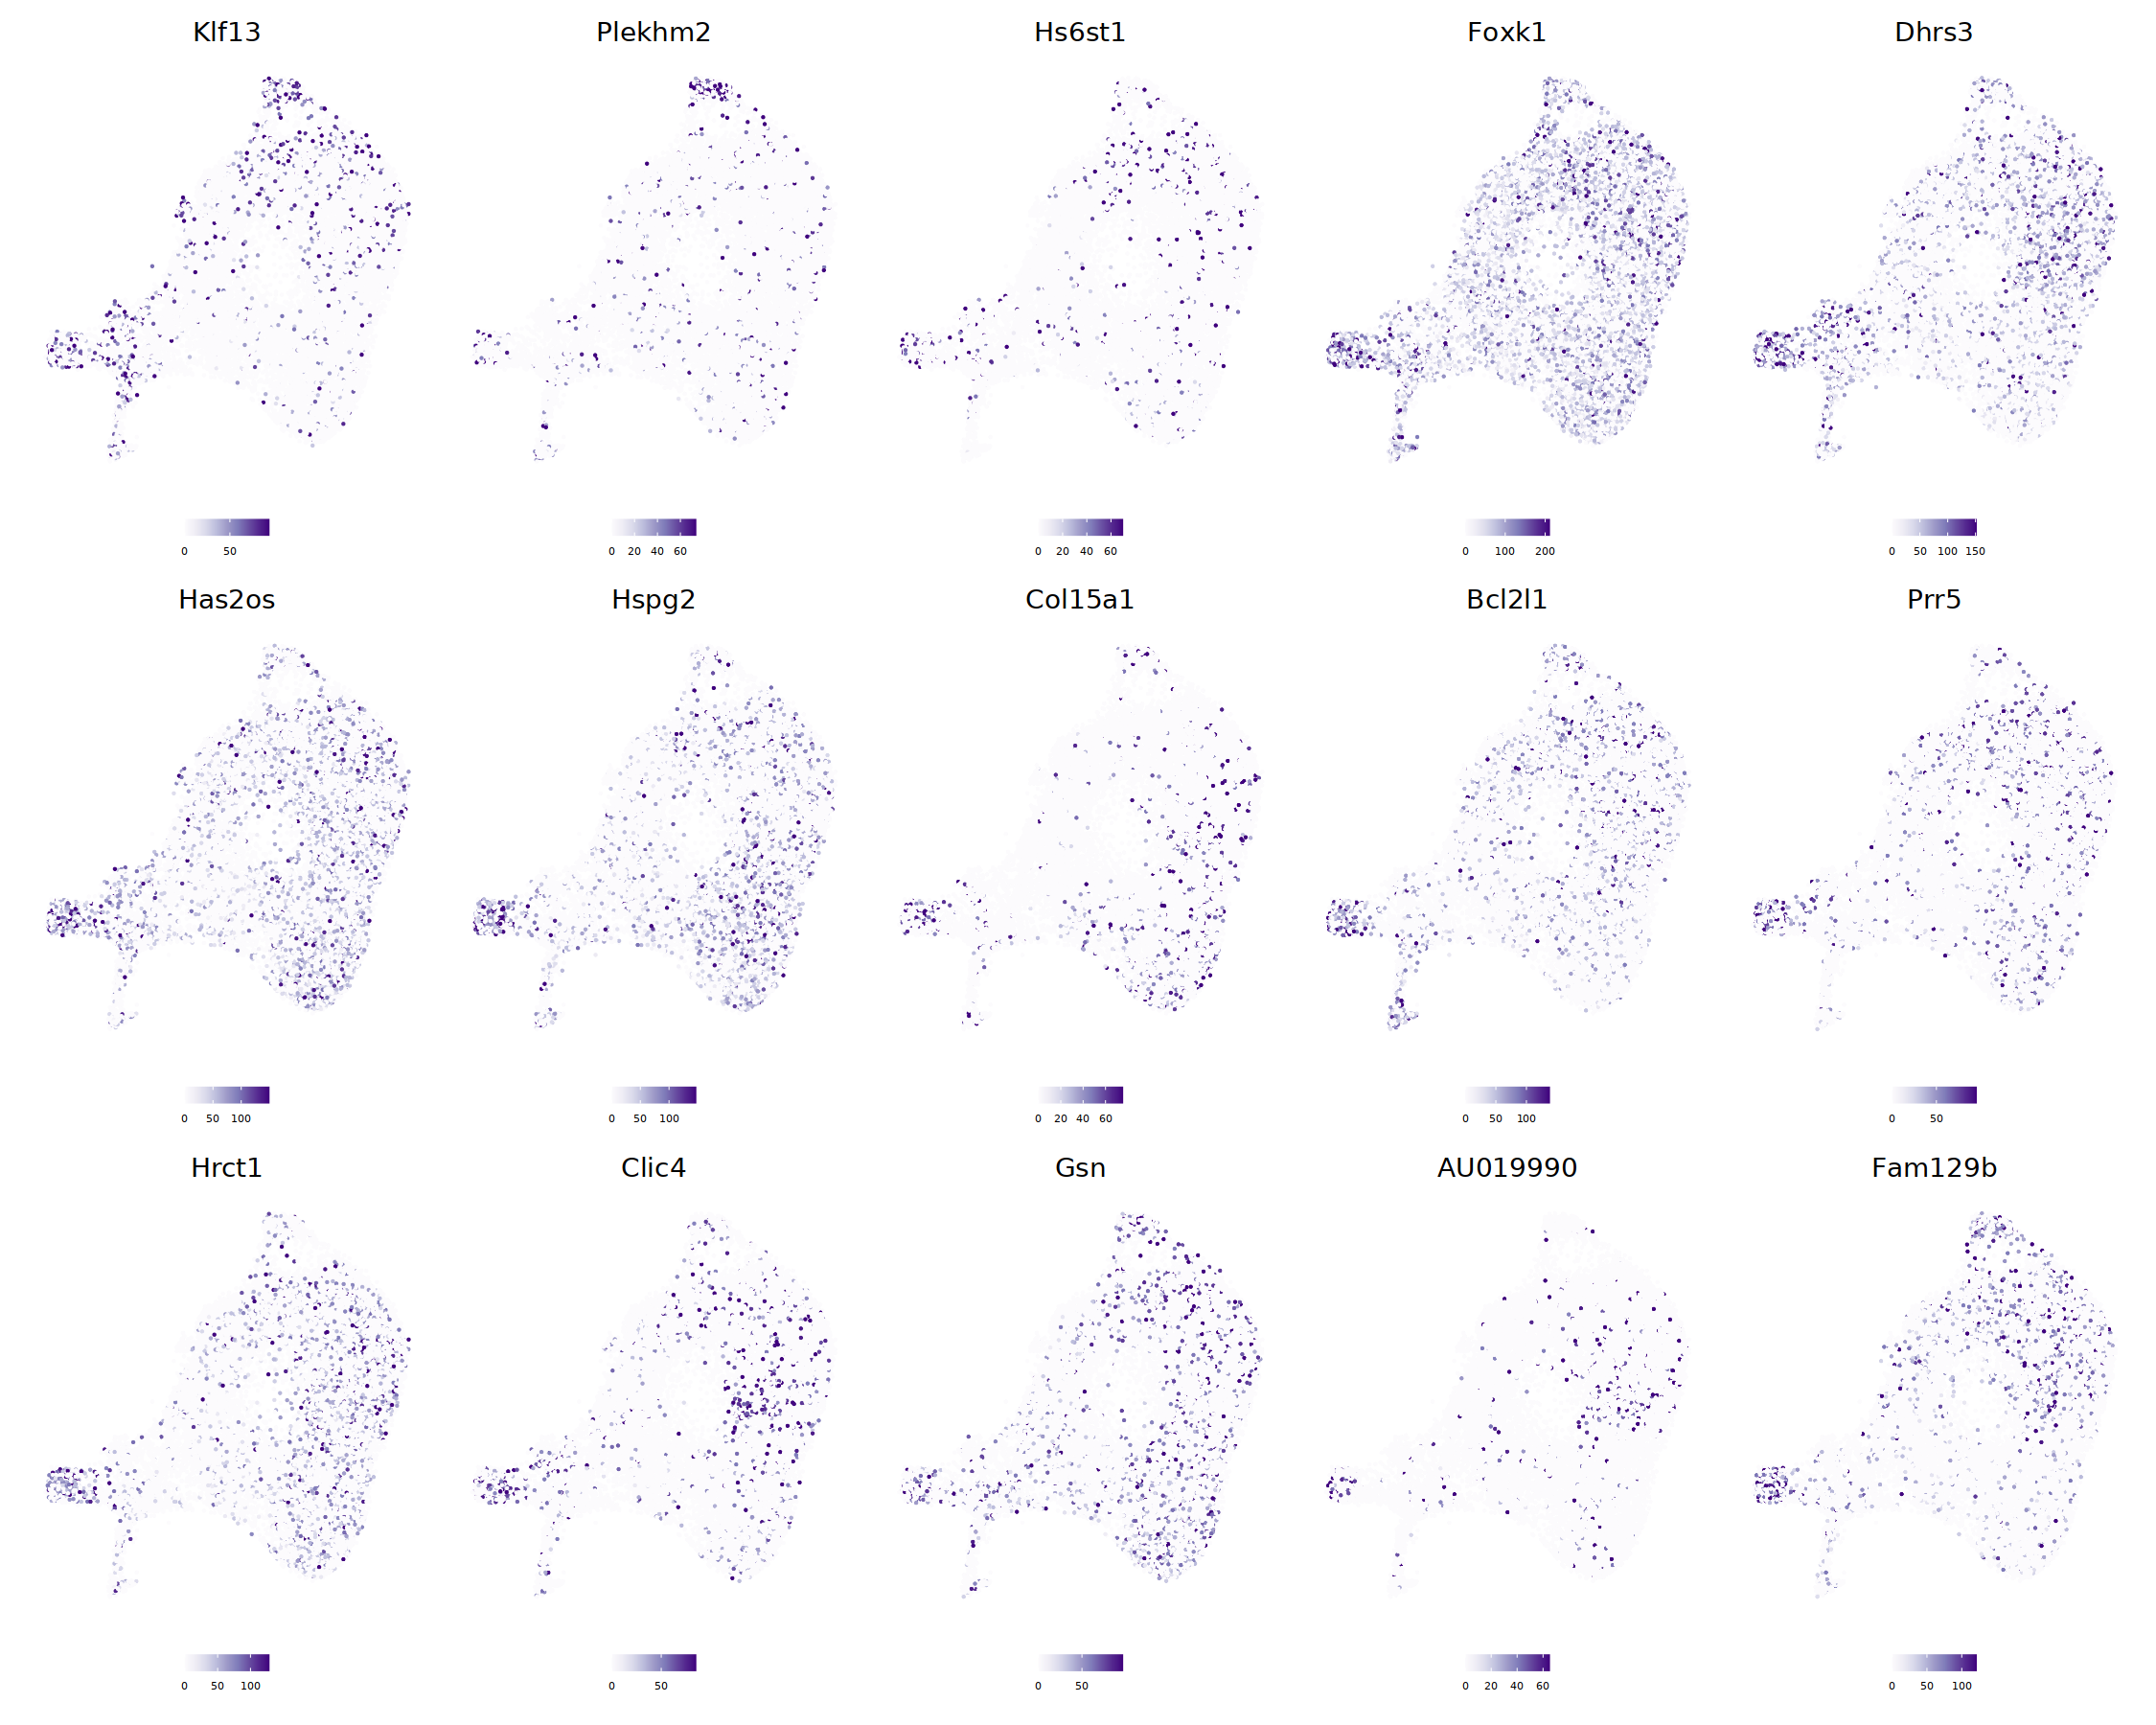

In [65]:
x <- module5$row_slice
options(repr.plot.width=15, repr.plot.height=12, repr.plot.res = 150)
p1 <- plotMarker2D(umap,dorcMat,markers = x[1],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[1])
p2 <- plotMarker2D(umap,dorcMat,markers = x[2],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[2])
p3 <- plotMarker2D(umap,dorcMat,markers = x[3],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[3])
p4 <- plotMarker2D(umap,dorcMat,markers = x[4],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[4])
p5 <- plotMarker2D(umap,dorcMat,markers = x[5],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[5])
p6 <- plotMarker2D(umap,dorcMat,markers = x[6],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[6])
p7 <- plotMarker2D(umap,dorcMat,markers = x[7],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[7])
p8 <- plotMarker2D(umap,dorcMat,markers = x[8],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[8])
p9 <- plotMarker2D(umap,dorcMat,markers = x[9],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[9])
p10 <- plotMarker2D(umap,dorcMat,markers = x[10],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[10])
p11 <- plotMarker2D(umap,dorcMat,markers = x[11],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[11])
p12 <- plotMarker2D(umap,dorcMat,markers = x[12],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[12])
p13 <- plotMarker2D(umap,dorcMat,markers = x[13],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[13])
p14 <- plotMarker2D(umap,dorcMat,markers = x[14],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[14])
p15 <- plotMarker2D(umap,dorcMat,markers = x[15],pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_purple") + ggtitle(x[15])
(p1|p2|p3|p4|p5)/(p6|p7|p8|p9|p10)/(p11|p12|p13|p14|p15)

In [21]:
#### DORC plot ####
options(repr.plot.width=18, repr.plot.height=5.6)
gene = c('Lef1','Ebf1')
plots <- vector("list", length(gene))

for (i in seq_along(gene)) {
  TF <- gene[i]
  plots[[i]] <- plotMarker2D(umap.fib, dorcMat.s, markers = TF, pointSize = 0.1, maxCutoff = "q0.99", colorPalette = "brewer_heat") + ggtitle(TF)
}

library(cowplot)
plot_grid(plotlist = plots, ncol = 3)
# ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/celline/mouseskin/DORC_Runx.pdf',plot_grid(plotlist = plots, ncol = 3),width = 18, height = 5.6)

Plotting  Lef1 


Loading required package: ggrastr



Plotting  Ebf1 


In [9]:
'Alx4' %in% rownames(dorcMat.s)

[1] TRUE

Plotting  Alx4 


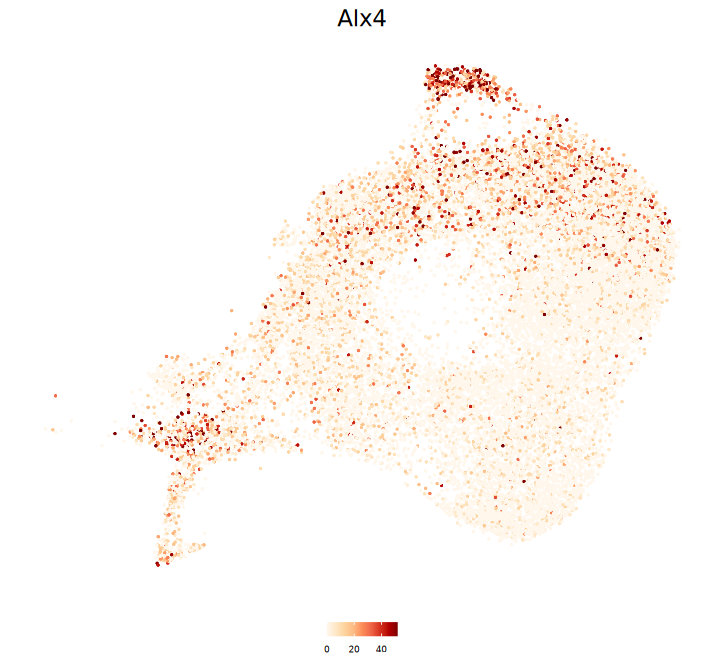

In [10]:
options(repr.plot.width=6, repr.plot.height=5.6)
TF <- 'Alx4'
motif <- 'MA0853.1'
plotMarker2D(umap.fib_nonchod,dorcMat.s,markers = TF, pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_heat") + ggtitle(TF)

Plotting  Runx2 


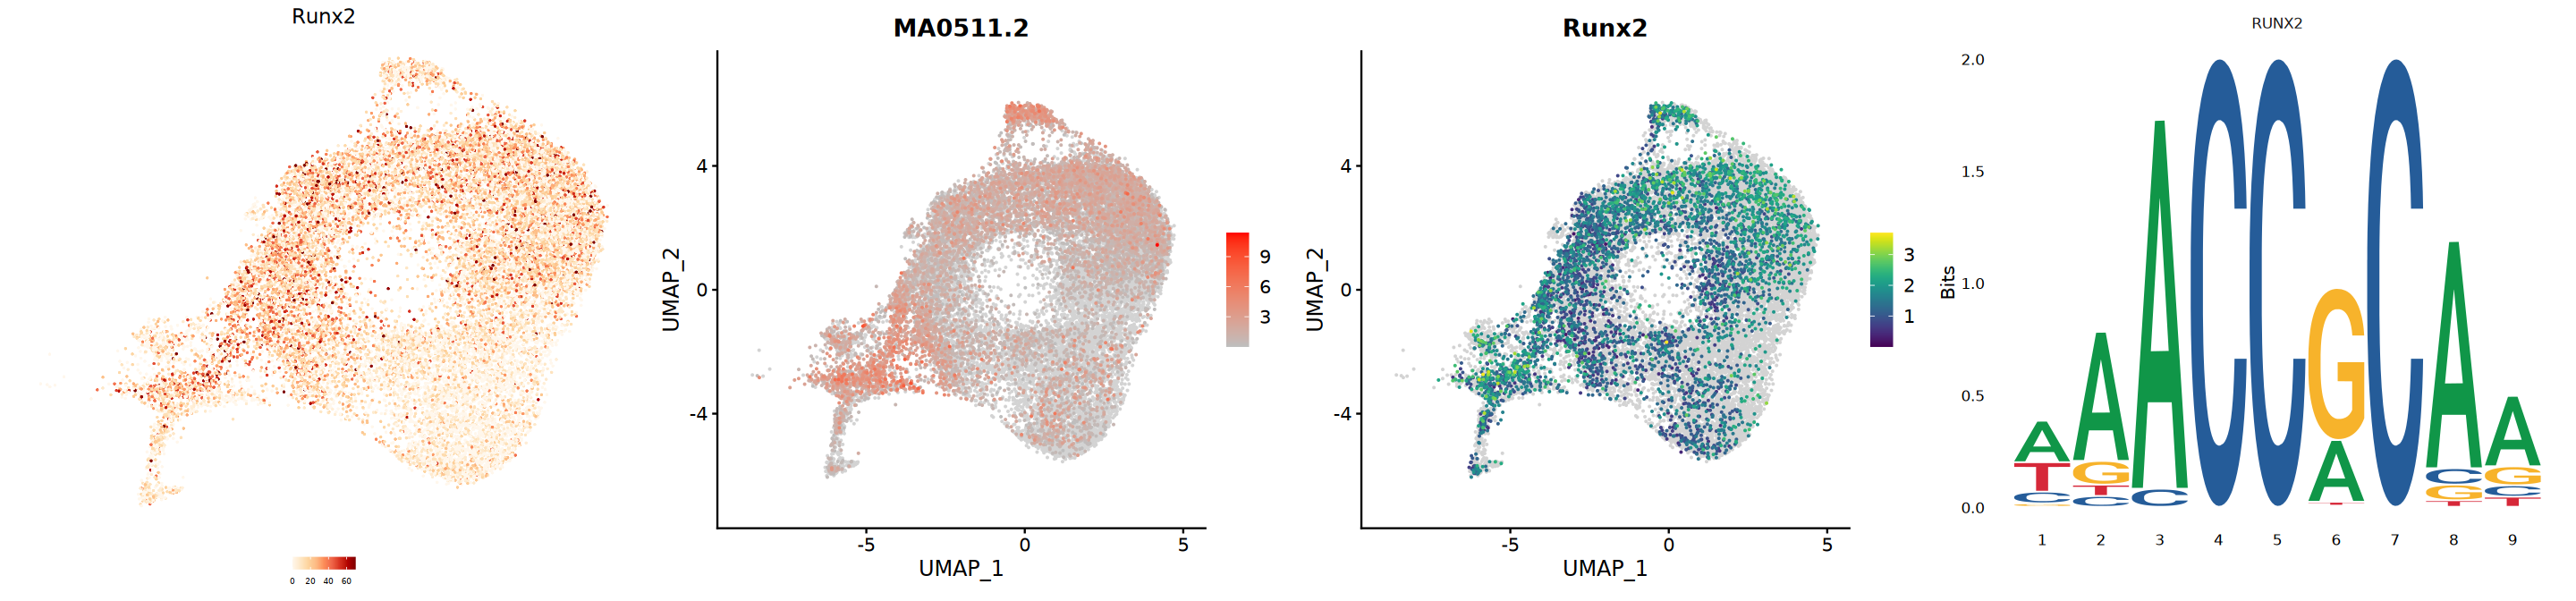

In [15]:
options(repr.plot.width=24, repr.plot.height=5.6)
TF <- 'Runx2'
motif <- 'MA0511.2'
p1 <- plotMarker2D(umap.fib_nonchod,dorcMat.s,markers = TF, pointSize = 0.1,maxCutoff = "q0.99",colorPalette = "brewer_heat") + ggtitle(TF)
DefaultAssay(skin.fib_nonchod) <- 'chromvar'
p2 <- FeaturePlot_scCustom(seurat_object = skin.fib_nonchod, colors_use = c("grey","red"), reduction='umap', features = motif) # min.cutoff=0, max.cutoff=6
DefaultAssay(skin.fib_nonchod) <- 'RNA'
p3 <- FeaturePlot_scCustom(seurat_object = skin.fib_nonchod, colors_use = viridis_light_high, features = TF, min.cutoff=0,max.cutoff=5)
DefaultAssay(skin.fib_nonchod) <- 'ATAC'
p4 <- MotifPlot(object = skin.fib_nonchod, motifs = motif) 
plot_grid(p1, p2, p3, p4, axis = "b", align = "h",ncol = 4)
ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/TF_visualization/Runx2_visualization.pdf',plot_grid(p1, p2, p3, p4, axis = "b", align = "h",ncol = 4),width = 24, height = 5.6)

---

## module GRNplot

In [18]:
library(ggraph)
library(tidygraph)
library(tidyverse)
library(igraph)
sliceModule <- function(mat = regMat, row_sel = c('LPL','MPEG1'), col_sel = c('STAT5A','SHOX')) {
    rowid <- rownames(mat)
    colid <- colnames(mat)
    
    rowid_start <- grep(paste0("^",row_sel[1],"$"), rowid)
    rowid_end <- grep(paste0("^",row_sel[2],"$"), rowid)
    stopifnot(rowid_start < rowid_end)
    row_slice <- rowid_start:rowid_end
    
    colid_start <- grep(paste0("^",col_sel[1],"$"), colid ) #exact match
    colid_end <- grep(paste0("^",col_sel[2],"$"), colid)
    stopifnot(colid_start < colid_end)
    col_slice <- colid_start:colid_end
    
    return(list(matSlice = mat[row_slice,col_slice], 
                row_slice=rowid[row_slice],
                col_slice = colid[col_slice]
                )
          )
}
library(networkD3)
getNetworkDataList <- function(figR.d, score.cut = 1.2, DORCs = NULL, TFs = NULL,save=NULL,data.rna = NULL, cid.rna = NULL,data.dorc=NULL, cid.dorc = NULL, module = NULL){
    ##copy from plotfigRNetwork
    #net.dat <- figR.d %>% filter(abs(Score) >= score.cut) #both positive and negative regulation

    net.dat <- figR.d %>% filter(Score >= score.cut) #only positive regulation
    
    if (!is.null(TFs))  #filter all tf target, not only in tf-target heatmap row
        net.dat <- net.dat %>% filter(Motif %in% TFs)  
#     if (!is.null(DORCs)) 
#         net.dat <- net.dat %>% filter(DORC %in% DORCs)

#     if (!is.null(TFs) & !is.null(DORCs)) 
#         net.dat <- net.dat %>% filter(Motif %in% TFs & DORC %in% DORCs) 
    
 
#     if (!is.null(DORCs) & !is.null(TFs)) 
#         net.dat <- net.dat %>% filter(DORC %in% DORCs | Motif %in% TFs)
    
    #net.dat$Motif <- paste0(net.dat$Motif, ".")
    net.dat$Motif <- paste0(net.dat$Motif)
    net.dat$DORC <- paste0(net.dat$DORC)
    
    tflist.tab <- split(x = net.dat, f = net.dat$Motif)
    
    stopifnot(sum(table(names(tflist.tab) %in% TFs)) == length(tflist.tab))
    
    
    ##1 for plorTFgraphList
    tflist <- lapply(tflist.tab, FUN = function(x){ x$DORC  } )
    
    
    #2 for cytoscape (simple but pretty network with two layers)??
    
    ##node table
    dorcs <- data.frame(name = unique(net.dat$DORC), group = "DORC", 
        size = 3)
    tfs <- data.frame(name = unique(net.dat$Motif), group = "TF", 
        size = 8)
    nodes <- rbind(dorcs, tfs)

    ##add node data (tf and dorc gene expr 
    stopifnot(cid.rna %in% colnames(data.rna))
    stopifnot(cid.dorc %in% colnames(data.dorc))
        
    value.rna <- data.rna[as.character(nodes$name),cid.rna] #color?
    value.dorc <- data.dorc[as.character(nodes$name),cid.dorc] #size?
    
    stopifnot(length(value.rna) == nrow(nodes) )
    stopifnot(length(value.dorc) == nrow(nodes) )
    
    nodes$value.rna <- value.rna
    nodes$value.dorc <- value.dorc
    
    
    ##is in tf-target heatmap rowid?
    
    nodes$isinHeatmap <- ifelse(nodes$name %in% DORCs,'yes','no')
    
    
    #rename dorc and tf id, if one is both dorc and tf
    #sum(duplicated(nodes$name))
    nodes$name <- paste0(nodes$name)
    
    idx <- which(duplicated(nodes$name))
    nodes$name[idx] <- paste0( nodes$name[idx],'_',nodes$group[idx]  )
    
    stopifnot( sum(duplicated(nodes$name) ) == 0 )
    
    #nodes[duplicated(nodes$name),]
    #nodes[which(nodes$name == "ZNF467"),]
    
    ###edge table
    edges <- as.data.frame(net.dat)
    
    links <- data.frame(
        source = unlist(lapply(edges$Motif, function(x) {
                        which(nodes$name == x) })),
        target = unlist(lapply(edges$DORC, function(x) {
                        which(nodes$name == x) })),
        
        corr = edges$Corr, 
        enrichment = edges$Enrichment.P
    )
    links$Value <- scales::rescale(edges$Score) * 20
    
    links$source_name <- as.character(nodes$name[links$source])
    links$target_name <- as.character(nodes$name[links$target])
    
    stopifnot(all.equal(links$source_name,edges$Motif)) #TRUE
    stopifnot(all.equal(links$target_name,edges$DORC)) #TRUE
    stopifnot(all.equal(links$corr,edges$Corr))#TRUE
    stopifnot(all.equal(links$enrichment,edges$Enrichment.P)) #TRUE
    
    
    if(save){    
       write.table(x = nodes,file = paste0('plot_network/nodes.table.',module,'-cidrna',cid.rna,'-ciddorc',cid.dorc,'.txt'),sep = '\t',quote = FALSE, row.names = FALSE, col.names = TRUE)
       write.table(x = edges,file = paste0('plot_network/edges.table.',module,'-cidrna',cid.rna,'-ciddorc',cid.dorc,'.txt'),sep = '\t',quote = FALSE, row.names = FALSE, col.names = TRUE)
    
    }
    
    
   return(tflist)   
    
}


Attaching package: ‘ggraph’


The following object is masked from ‘package:sp’:

    geometry



Attaching package: ‘tidygraph’


The following objects are masked from ‘package:IRanges’:

    active, slice


The following objects are masked from ‘package:S4Vectors’:

    active, rename


The following object is masked from ‘package:stats’:

    filter


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks ma

In [11]:
##module1
module1 <- sliceModule(regMat, row_sel = c('Nrip2','C230057M02Rik'), col_sel = c('Gli1','Tcf4'))
##module2
module2 <- sliceModule(regMat, row_sel = c('Mboat2','Gm33732'), col_sel = c('Sox11','Tfcp2'))
##module3
module3 <- sliceModule(regMat, row_sel = c('Jak2','Pdgfb'), col_sel = c('Sox9','Hoxa10'))
##module4
module4 <- sliceModule(regMat, row_sel = c('Dtnbp1','Sbsn'), col_sel = c('Klf4','Gli1'))
##module5
module5 <- sliceModule(regMat, row_sel = c('1700025G04Rik','Lipg'), col_sel = c('Sox9','Foxc1'))
##module6
module6 <- sliceModule(regMat, row_sel = c('Gm12708','Fbxo32'), col_sel = c('Creb5','Plagl1'))

---
### module result

In [102]:
library(igraph)
library(ggraph)
plotTFGraph_list <- function(tflist = NULL,layout = NULL, seed = NULL, downsample = NULL, geneHi = NULL,node_label = NULL, save = NULL,width= NULL, height = NULL){
    #need igraph, ggraph
    #input TF-target list (or nestted list), plot igraph by ggraph with kk layout
    
      set.seed(seed)
      if(save){
        tflist.df <- list2df(tflist)
        write.table(tflist.df, file =  paste('plot_TF_regulon_network/',paste( names(tflist),collapse = '_'  ),'-tf-target.txt',sep='') ,col.names = TRUE, row.names = FALSE, sep = '\t',quote = FALSE)  #for cytoscape input
      }
    
     #downsampling but keep geneHi  
     if(is.numeric(downsample) ){
         tflist_downsample <- lapply(tflist,function(x){  
                            lengthx <- length(x)
                            if(lengthx >= 200){
                              geneHi_hit <- x[x %in% geneHi]
                              x <- x[!x %in% geneHi]
                              return(c(sample(x,size = downsample*lengthx,replace = FALSE),geneHi_hit) )
                            }else{return(x)}
                          } 
                         )
      }else{ tflist_downsample <- tflist  }
    
      ##create graph
      g <- list2graph(tflist_downsample)
    
      #quick plot
      ##options(repr.plot.width= width, repr.plot.height = height)
      ##set.seed(10);plot(g)
      
      ##set vertex attribute
      vtx <- igraph::V(g) #vertex
      n_vtx <- length(vtx)
      id_vtx <- names(vtx)
      
      geneHi_idx <- match(geneHi, id_vtx)
      geneHi_idx <- geneHi_idx[!is.na(geneHi_idx)]
      #id_vtx[geneHi_idx]
    
      n_pathvtx <- length(tflist)
      id_pathvtx <- names(tflist) 
    
      n_genevtx <- n_vtx - n_pathvtx
      id_genevtx <- id_vtx[-(1:n_pathvtx)]
    
      path_size <- sapply(tflist, length)
      igraph::V(g)$size <- min(path_size)/2 #the default dot size
      
      igraph::V(g)$size[1:n_pathvtx] <- path_size
      
      ##also set each gene node size as foldchange
      #id_gene <- id_vtx[(n_pathvtx+1):n_vtx]
      
    
      V(g)$color <- "#B3B3B3"
      V(g)$color[1:n_pathvtx] <- "grey90"
      V(g)$color[geneHi_idx] <- 'red'
    
      #set edge attribute
      #edge <- igraph::E(g)
      E(g)$width <- 0.5
      E(g)$color <- 'darkgrey'
      #E(g)$betweenness <- edge.betweenness(g)
    
      ##quick plot 
      ##set.seed(10)
      ##options(repr.plot.width= width, repr.plot.height = height)
      ##plot(g)
    
     ##use pretty ggraph with layout kk
     n <- length(tflist)
    
     #node size
     cex_category = 3
     cex_gene = 1.5
     
     #label size
     node_label_size = NULL
     
     label_gene = 1
     cex_label_gene = 3
    
     label_category =1 
     cex_label_category = 4
    
     layout =  layout#'kk' #'circlepack'# 
     circular = FALSE
     colorEdge = FALSE
    
    node_scales <- c(rep(cex_category, n), rep(cex_gene, (length(V(g)) - n)))
    
    if (colorEdge) {
        E(g)$category <- rep(names(tflist), sapply(tflist, length))
        edge_layer <- geom_edge_link(aes_(color = ~category), alpha=.8) #change geom_edge to geom_edge_link
    } else {
        edge_layer <- geom_edge_link(alpha=.8, colour='darkgrey') #change geom_edge to geom_edge_link
    }
    
    show_legend <- c(FALSE, FALSE)
    names(show_legend) <- c("color", "size")
    
    set.seed(10)
    p <- ggraph(g, layout=layout, circular = circular)
    p <- p +
        edge_layer +
        #geom_node_point()
        geom_node_point(aes_(color=~I("#E5C494"), size=~size),
            data = p$data[1:n, ], show.legend = show_legend) +
        scale_size(range=c(3, 8) * cex_category) +
        ##ggnewscale::new_scale("size") +
    
        ##ggnewscale::new_scale_color() +
        geom_node_point(aes_(color=~color, size=~size),
            data = p$data[-(1:n), ], show.legend = show_legend) +
        ##geom_label(aes(x = x, y = y, label = name), nudge_y = 0.15, label.size = NA,fill = NA,size = 5) +
        scale_size(range=c(3, 3) * cex_gene) +
#         scale_colour_gradient2(name = "fold change", low = "blue",
#                                mid = "white", high = "red") +
        ggtitle(paste('TF-network ',paste( names(tflist),collapse = '_'  ),' layout:',layout,' downsample: ',downsample,sep='') ) +
        theme_void()+
        theme(legend.position = 'none')

    ##add node (category + gene) label with repelling
    if (node_label == "category") {
        if (utils::packageVersion("ggrepel") >= "0.9.0") {
            p <- p + geom_node_text(aes_(label=~name), data = p$data[1:n,],
                size = label_category * cex_label_category, bg.color = "white")
        } else {
            p <- p + geom_node_text(aes_(label=~name), data = p$data[1:n,],
                size = label_category * cex_label_category)
        }
    } else if (node_label == "gene") {
        if (utils::packageVersion("ggrepel") >= "0.9.0") {
            p <- p + geom_node_text(aes_(label=~name), data = p$data[-c(1:n),],
                repel=TRUE, size = label_gene * cex_label_gene, bg.color = "white")
        } else {
            p <- p + geom_node_text(aes_(label=~name), data = p$data[-c(1:n),],
            repel=TRUE, size = label_gene * cex_label_gene)
        }
    } else if (node_label == "all") {
        if (utils::packageVersion("ggrepel") >= "0.9.0") {
            p <- p + geom_node_text(aes_(label=~name), data = p$data[-c(1:n),],
                    repel=TRUE, size = label_gene * cex_label_gene, bg.color = "white") + 
                geom_node_text(aes_(label=~name), repel=TRUE,
                    size = label_category * cex_label_category, bg.color = "white", data = p$data[1:n,]) 
        } else {
            p <- p + geom_node_text(aes_(label=~name), data = p$data[-c(1:n),],
                    repel=TRUE, size = label_gene * cex_label_gene) + 
                geom_node_text(aes_(label=~name), data = p$data[1:n,],
                    repel=TRUE, size = label_category * cex_label_category)
        }

    }
    
    
    if(save){  
       pdf(file = paste('plot_network/',paste( names(tflist),collapse = '_'  ),'-tf-target.',layout,'.pdf',sep=''),width = width, height = height)
       print(p) 
       dev.off()
    }else{
      options(repr.plot.width= width, repr.plot.height = height)
      print(p)
    }
    return( list(g = g, p = p) )

}
list2graph <- function(inputList) {
    x <- list2df(inputList)
    g <- graph.data.frame(x, directed=FALSE)
    return(g)
}


list2df <- function(inputList) {
    # ldf <- lapply(1:length(inputList), function(i) {
    ldf <- lapply(seq_len(length(inputList)), function(i) {
        data.frame(categoryID=rep(names(inputList[i]),
                                  length(inputList[[i]])),
                   Gene=inputList[[i]])
    })

    do.call('rbind', ldf)
}

In [13]:
module_use = module5

In [14]:
######################################## 获取用于
# figR.d处理，score大于2，且在module中的motif，获得motif对应DORC的列表
net.dat <- figR.d %>% filter(Score >= 2)
net.dat <- net.dat %>% filter(Motif %in% module_use$col_slice)
net.dat$Motif <- paste0(net.dat$Motif)
net.dat$DORC <- paste0(net.dat$DORC)
tflist.tab <- split(x = net.dat, f = net.dat$Motif)
tflist <- lapply(tflist.tab, FUN = function(x){ x$DORC  } )
#
dorcs <- data.frame(name = unique(net.dat$DORC), group = "DORC", size = 3)
tfs <- data.frame(name = unique(net.dat$Motif), group = "TF", size = 8)
nodes <- rbind(dorcs, tfs)
nodes$isinHeatmap <- ifelse(nodes$name %in% module_use$row_slice,'yes','no')
nodes$name <- paste0(nodes$name)
idx <- which(duplicated(nodes$name))
nodes$name[idx] <- paste0( nodes$name[idx],'_',nodes$group[idx]  )
edges <- as.data.frame(net.dat)
# 去除数字的gene
cut <- dorcs[grep("Rik$", dorcs$name),]$name
nodes = nodes[!(nodes$name %in% cut),]
edges = edges[!(edges$DORC %in% cut),]
# link处理
links <- data.frame(
        source = unlist(lapply(edges$Motif, function(x) { which(nodes$name == x) })),
        target = unlist(lapply(edges$DORC, function(x) { which(nodes$name == x) })),
        corr = edges$Corr, 
        enrichment = edges$Enrichment.P
    )
links$Value <- scales::rescale(edges$Score) * 20
links$source_name <- as.character(nodes$name[links$source])
links$target_name <- as.character(nodes$name[links$target])
links <- links[order(links$source_name, links$target_name), ] # 排序
links

source target corr       enrichment   Value       source_name target_name 
30   46     25    0.06383345 3.251651e-04 0.3883507   Foxc1       Col2a1      
56   46     46    0.06925327 3.745542e-04 3.2196206   Foxc1       Foxc1       
66   46     51    0.06163204 1.839687e-03 1.8992220   Foxc1       Gm11217     
71   46     54    0.03166225 1.578538e-03 1.9919525   Foxc1       Gm13003     
81   46     63    0.02964485 1.040395e-04 3.2212952   Foxc1       Gm33782     
101  46     79    0.03476106 1.438443e-04 2.2675165   Foxc1       Ifnk        
154  46    126    0.06126880 6.833472e-04 0.9027952   Foxc1       Prdm16      
162  46    131    0.05205322 3.153594e-03 1.1270056   Foxc1       Ptpn14      
182  46    148    0.04285011 1.553184e-04 0.1229265   Foxc1       Sned1       
185  46    150    0.02798498 1.448098e-03 1.0169430   Foxc1       Sox5os4     
189  46    153    0.04134437 4.342451e-03 0.7466546   Foxc1       St3gal6     
196  46    157    0.03846025 3.104868e-03 1.4429197   Foxc1       Themis3     
209  46    168    0.02997067 1.235817e-04 2.0266385   Foxc1       Xab2        
7   178      6    0.03429724 1.790134e-03 1.7828373   Foxc2       Aifm2       
203 178    163    0.03125342 1.979379e-05 1.3566033   Foxc2       Trp53cor1   
59   47     47    0.04364068 3.515916e-03 1.3353860   Foxk1       Foxk1       
204 182    163    0.03479791 9.633077e-04 2.0787605   Foxl1       Trp53cor1   
129 110    106    0.05033807 3.256693e-03 0.7334444   Nfatc2      Myo10       
178 110    145    0.04015455 2.567699e-03 0.3399260   Nfatc2      Slc6a6      
197 110    158    0.03918142 9.574096e-06 0.4220228   Nfatc2      Tm4sf1      
1   126      1    0.03468330 1.354600e-03 1.2766511   Prdm16      Actn1       
4   126      4    0.02712363 4.408428e-03 0.6558585   Prdm16      Adora2a     
5   126      5    0.05261564 2.910617e-04 4.4944989   Prdm16      Ahdc1       
11  126     10    0.07190567 4.012244e-03 1.1680603   Prdm16      B4galnt3    
13  126     11    0.03240826 3.335245e-03 0.3341643   Prdm16      Bcl2l1      
17  126     14    0.03705435 2.490131e-03 0.8178650   Prdm16      Ccdc85c     
23  126     20    0.06420651 3.035003e-03 1.5093333   Prdm16      Chst3       
25  126     21    0.02586514 5.752717e-04 0.3925654   Prdm16      Clcnka      
26  126     22    0.04647920 8.643054e-04 2.1209150   Prdm16      Clic4       
33  126     27    0.08543950 3.622174e-03 1.2903226   Prdm16      Creb3l2     
⋮   ⋮      ⋮      ⋮          ⋮            ⋮           ⋮           ⋮           
165 174    132    0.03696952 7.421662e-05  0.75856526 Sox9        Ptpn2       
166 174    133    0.12055024 4.853253e-08 15.74355594 Sox9        Rab11fip4os2
167 174    134    0.03090888 4.725729e-12  1.36353330 Sox9        Rarg        
169 174    136    0.03937171 2.961350e-06  0.51515925 Sox9        Rcan1       
170 174    137    0.03551296 1.148085e-05  0.42929395 Sox9        Rin2        
172 174    139    0.07796191 7.916975e-06  9.21793148 Sox9        Sctr        
173 174    140    0.04385667 7.098134e-09  4.41871584 Sox9        Sdc3        
174 174    141    0.03288346 1.740640e-06  0.61789132 Sox9        Sec14l1     
175 174    142    0.04085681 3.611868e-08  6.59658399 Sox9        Sept5       
176 174    143    0.04174767 1.340365e-08  0.44743449 Sox9        Sh3bp5      
179 174    146    0.05036770 9.088420e-09 10.37580088 Sox9        Smad7       
181 174    147    0.06397763 1.299270e-06  9.73920432 Sox9        Smoc1       
183 174    148    0.07454642 6.916284e-06  9.20280140 Sox9        Sned1       
184 174    149    0.11414081 1.425618e-06 11.43375658 Sox9        Sorbs1      
187 174    151    0.10658937 5.737331e-07 12.60819671 Sox9        Sox6        
188 174    152    0.02877781 5.174749e-09  1.21516791 Sox9        Spns2       
190 174    153    0.03561771 3.087616e-11  0.48065604 Sox9        St3gal6     
191 174    154    0.10778941 2.247892e-07 13.82077957 Sox9        Stk10       
194 174    155    0.03012996 5.177549e-07  0.01364579 

In [15]:
# 创建igraph对象
g_links <- links[,c('source_name', 'target_name', 'corr')] # TF \ DORCs \ corr
g <- graph_from_data_frame(g_links)
# gene used
vtx <- igraph::V(g)
gene.use <- unique(names(vtx))
n_pathvtx <- length(unique(links$source_name))

In [17]:
skin.fib <- readRDS('/hwfssz5/ST_SUPERCELLS/P21Z10200N0090/caipengfei/workspace/temp/scCAT/Skin_fibroblast.rds')
dorcMat <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_dorcmat_modified.rds')
# DORC
dorcmat <- as.data.frame(dorcMat)[gene.use,]
# data.frame(DORC = log2(rowSums(dorcmat)+1))
DORCexpre <- data.frame(DORC = log2(rowMeans(dorcmat)+1))
# RNA
RNAmat = as.data.frame(scale(skin.fib@assays$RNA@data[gene.use,]))
RNAmat[is.na(RNAmat)] <- 0 # 去除na
RNAexpre <- data.frame(RNA = rowMeans(RNAmat))
# combine
expre <- cbind(DORCexpre,RNAexpre)
expre[,"TF"] <- 16
expre[1:n_pathvtx,"TF"] <- 18
expre

DORC      RNA          TF
Foxc1        2.7643281 -0.224772583 18
Foxc2        0.4033330 -0.263801926 18
Foxk1        4.9146428  0.041436239 18
Foxl1        2.0632829 -0.269165582 18
Nfatc2       4.2918948  0.186745345 18
Prdm16       1.9918732  0.102022853 18
Sox13        1.5260317 -0.191892917 18
Sox8         1.2662521 -0.254406787 18
Sox9         2.6109221 -0.125030039 18
Col2a1       3.2076777  0.409282510 16
Gm11217      1.5004812 -0.261125985 16
Gm13003      1.3137750 -0.258394775 16
Gm33782      0.7813400 -0.256015898 16
Ifnk         1.4459841 -0.268947635 16
Ptpn14       1.7606702  0.517456160 16
Sned1        2.3186470  0.006920775 16
Sox5os4      0.6095599 -0.244576354 16
St3gal6      2.5854099 -0.094245625 16
Themis3      1.1535837 -0.251907690 16
Xab2         3.7253464 -0.196717216 16
Aifm2        1.2925548 -0.236024210 16
Trp53cor1    1.8842175 -0.204483913 16
Myo10        2.4221079  0.591558484 16
Slc6a6       3.4184312  0.135983360 16
Tm4sf1       2.6257163 -0.208410984 16
Actn1        2.4349455  0.326926701 16
Adora2a      0.8687110 -0.232812360 16
Ahdc1        3.4135498  0.341302409 16
B4galnt3     1.3211345 -0.175868974 16
Bcl2l1       3.4017771  0.003410358 16
⋮            ⋮         ⋮            ⋮ 
Pde9a        1.3625397 -0.16587245  16
Phlda1       2.6222434 -0.21395577  16
Plagl1       1.6081031  1.28683933  16
Plcg2        1.0835705 -0.17259173  16
Plekhm2      1.8078127  0.03473691  16
Prr5         2.7023433 -0.20094025  16
Ptpn2        2.9125809  0.21792443  16
Rab11fip4os2 2.3863979 -0.26318957  16
Rarg         4.2957782  0.09177047  16
Rcan1        4.2364483  0.10718652  16
Rin2         2.1387549  0.47546902  16
Sctr         1.1376602 -0.22991902  16
Sdc3         2.4676422 -0.02414566  16
Sec14l1      2.5996715  0.01922775  16
Sept5        1.8306037 -0.21089898  16
Sh3bp5       2.7048795 -0.01171792  16
Smad7        4.1854871 -0.03998615  16
Sorbs1       1.7565864  0.36110575  16
Spns2        1.3296429 -0.21619331  16
Stk10        1.7687009  0.05201615  16
Tgm2         2.6908112 -0.21075924  16
Tram2        3.8847958  0.46427707  16
Trim47       3.0114438 -0.22375717  16
Vill         2.5942978 -0.19259421  16
Whrn         0.8541923 -0.09633027  16
Wwp2         2.7280373  0.13889723  16
Ypel2        2.0736038 -0.10231937  16
Zc3h12d      1.6525331 -0.23514273  16
Zcchc14      2.5507006  0.22093040  16
Zfpm1        2.8060334 -0.10543683  16

In [18]:
###### 修改节点 ######
# gene expression 节点颜色
range(expre$RNA) #-0.215450614377099  5.80248130151223
color1 = colorRampPalette(colors = c("#5567B1","#B3D5F1","#F8FFEC"))(20)
color2 = colorRampPalette(colors = c("#F8FFEC","#F0686C"))(20) # 100渐变色
x1 <- as.numeric(cut(expre$RNA, breaks = seq(-0.5, 0, length.out = 20)))
x2 <- as.numeric(cut(expre$RNA, breaks = seq(0, 2, length.out = 20)))
# 根据区块将对应的值贴上颜色
palette1 <- color1[x1]
palette2 <- color2[x2]
palette <- c()
for (i in seq_along(palette1)) {
  if (is.na(palette1[i])) {
    palette[i] <- palette2[i]
  } else {
    palette[i] <- palette1[i]
  }
}
# palette[which(rownames(expre) %in% c("Tcf4","Fgfr2","Zeb2","Agap1"))] <- "#F0686C"  # 将超出的部分定为最红
V(g)$color <- palette # 存入
# DORC accessibility 节点大小
range(expre$DORC)
map <- function(data, MIN, MAX) {
  d_min <- max(data)
  d_max <- min(data)
  return(MIN + (MAX - MIN) / (d_max - d_min) * (data - d_min))
}
DORCsize <- map(expre$DORC,1,10) * 1.1
V(g)$size <- DORCsize
###### 修改edge ######
#E(g)$weight <- links$corr/3 # 添加相关性信息

[1] -0.2691656  2.9312938

[1] 0.403333 4.914643

In [82]:
# plot with ggraph
n <- length(g_links)
show_legend <- c(FALSE, FALSE)
names(show_legend) <- c("color", "size")
p <- ggraph(g, layout='nicely') + geom_edge_link(alpha=.8, colour='darkgrey')  #'kk' #'circlepack'# 
options(repr.plot.width=15, repr.plot.height=15)
set.seed(100)
l <- layout_with_fr(g)
plot(g, layout=l, vertex.frame.color='darkgrey',edge.arrow.size = .2,edge.curved=0.1,vertex.label.cex=0.8)  #edge.arrow.size=1,edge.arrow.width=1,edge.lty=4

---

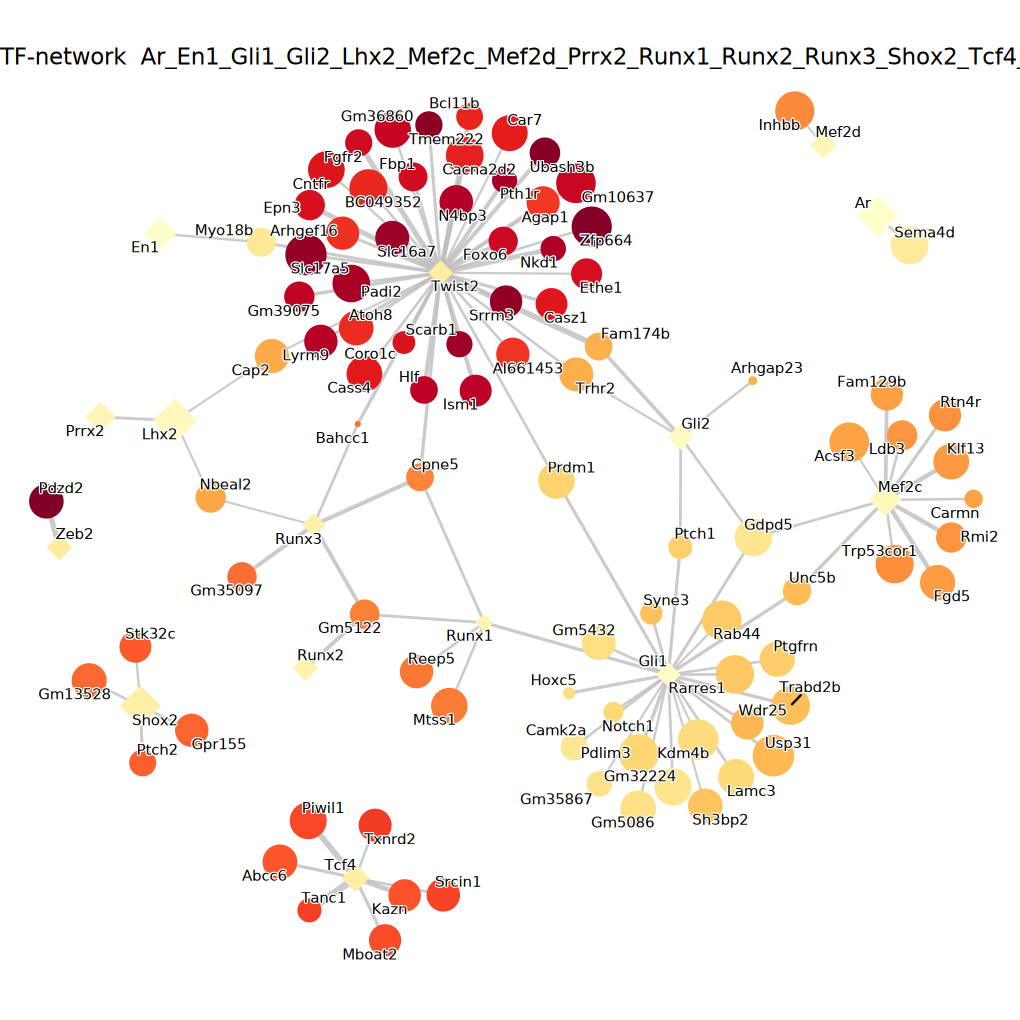

In [69]:
# module1
options(repr.plot.width=8.5, repr.plot.height=8.5)
set.seed(101)
p1= g %>% as_tbl_graph() %>% activate(nodes) %>% mutate(degree  = centrality_degree()) %>% 
      ggraph(layout='nicely') + geom_edge_link(aes(edge_width=links$corr), alpha=.8, colour='grey') + scale_edge_width_continuous(range = c(0.4,1.5)) +
      geom_node_point(aes(size = size), shape=expre$TF, color = cols_f(vcount(g)),show.legend = F) + scale_size(range=c(1, 11) * 1.1) + scale_color_manual(values = cols_f(ecount(g)))+ 
      geom_node_text(aes(label= name), repel=TRUE, size = 3, bg.color = "white") + 
      ggtitle(paste('TF-network ',paste(names(tflist),collapse = '_'  )) ) + theme_void()+ theme(legend.position = 'none') + theme_void()+theme(legend.position = 'none') + theme(legend.position = 'none')+
      coord_equal() 
      #geom_edge_arc(aes(edge_width=links$corr), alpha=.8, colour='grey',strength = 0.05) 设置线条圆滑
p1
ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/GRN_module1.pdf',p1,width = 9, height = 9)

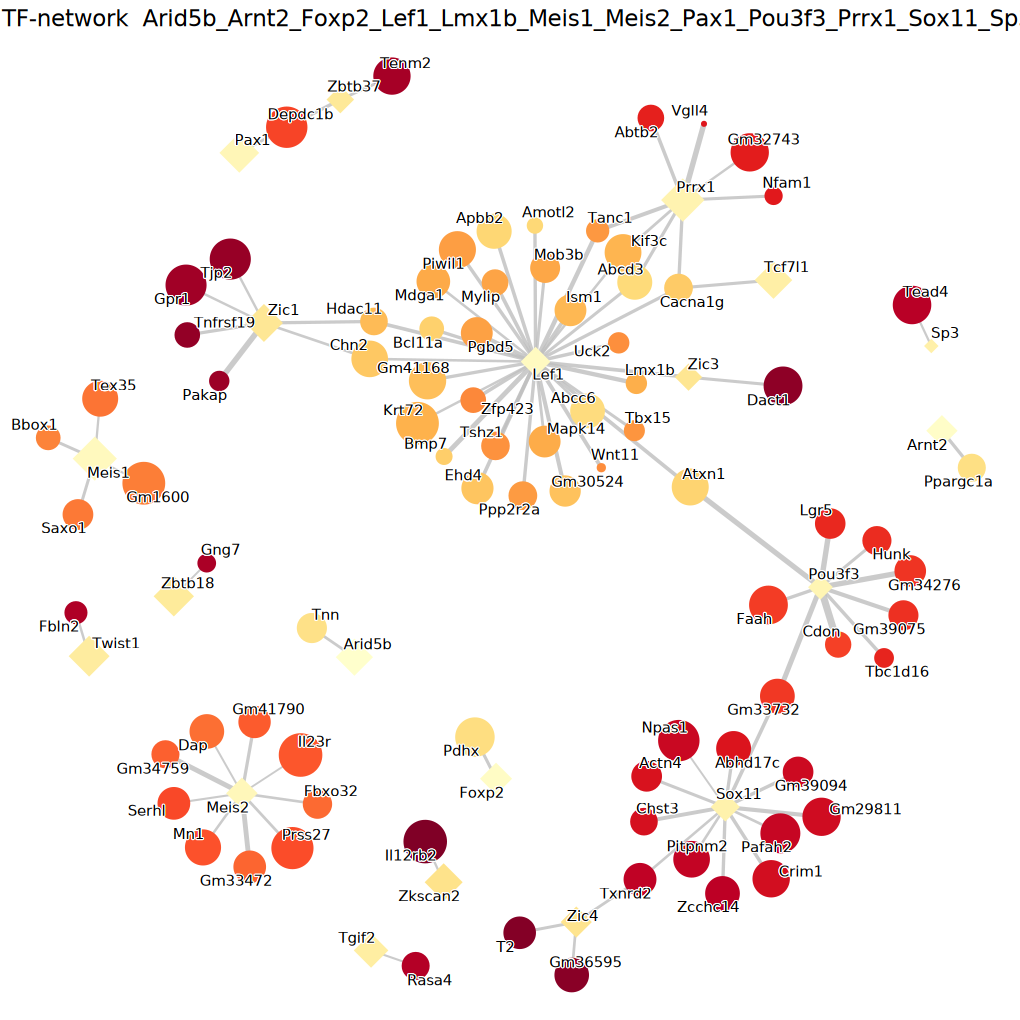

In [76]:
# module2
options(repr.plot.width=8.5, repr.plot.height=8.5)
set.seed(101)
p1= g %>% as_tbl_graph() %>% activate(nodes) %>% mutate(degree  = centrality_degree()) %>% 
      ggraph(layout='nicely') + geom_edge_link(aes(edge_width=links$corr), alpha=.8, colour='grey') + scale_edge_width_continuous(range = c(0.4,1.5)) +
      geom_node_point(aes(size = size), shape=expre$TF, color = cols_f(vcount(g)),show.legend = F) + scale_size(range=c(1, 11) * 1.1) + scale_color_manual(values = cols_f(ecount(g)))+ 
      geom_node_text(aes(label= name), repel=TRUE, size = 3, bg.color = "white") + 
      ggtitle(paste('TF-network ',paste(names(tflist),collapse = '_'  )) ) + theme_void()+ theme(legend.position = 'none') + theme_void()+theme(legend.position = 'none') + theme(legend.position = 'none')+
      coord_equal() 
      #geom_edge_arc(aes(edge_width=links$corr), alpha=.8, colour='grey',strength = 0.05) 设置线条圆滑
p1
ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/GRN_module2.pdf',p1,width = 8.5, height = 8.5)

Warning message:
“ggrepel: 121 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


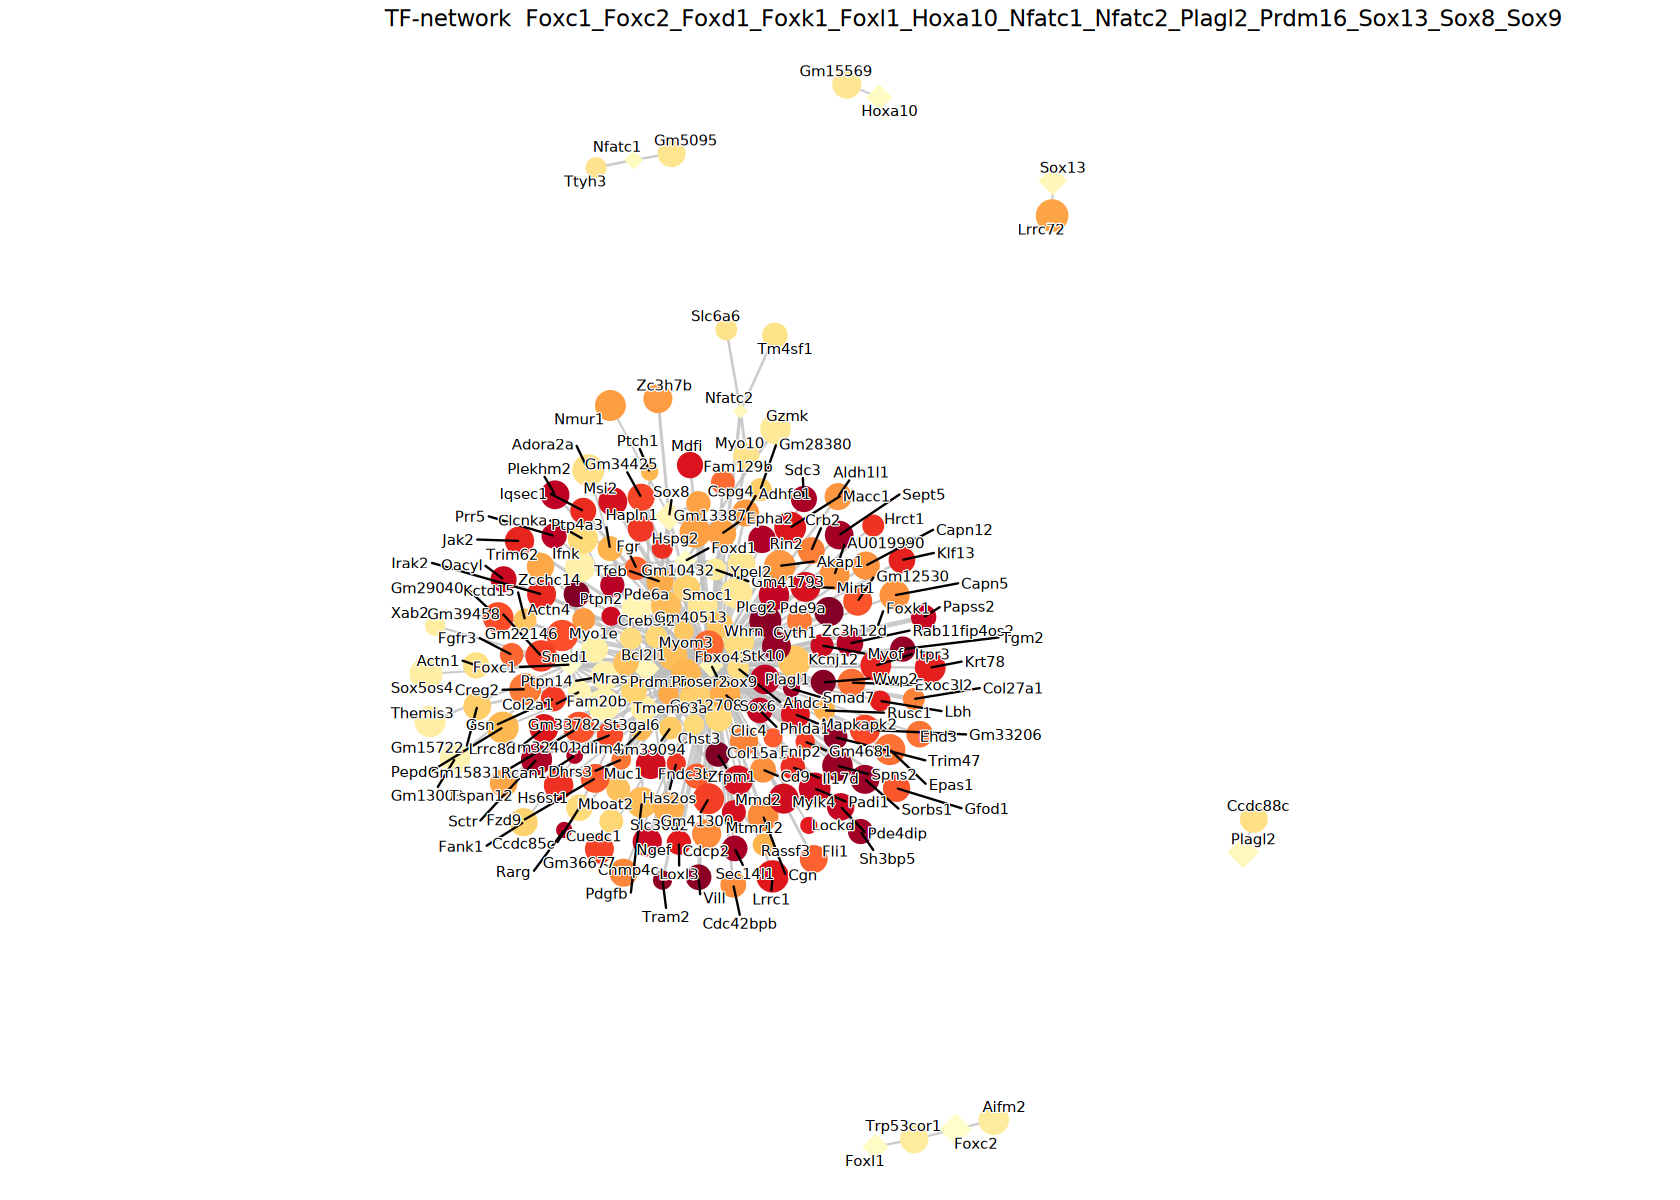

In [98]:
# module3
options(repr.plot.width=14, repr.plot.height=10)
set.seed(101)
p1= g %>% as_tbl_graph() %>% activate(nodes) %>% mutate(degree  = centrality_degree()) %>% 
      ggraph(layout='graphopt') + geom_edge_link(aes(edge_width=links$corr), alpha=.8, colour='grey') + scale_edge_width_continuous(range = c(0.4,1.5)) +
      geom_node_point(aes(size = size), shape=expre$TF, color = cols_f(vcount(g)),show.legend = F) + scale_size(range=c(1, 8) * 1.1) + scale_color_manual(values = cols_f(ecount(g)))+ 
      geom_node_text(aes(label= name), repel=TRUE, size = 3, bg.color = "white") + 
      ggtitle(paste('TF-network ',paste(names(tflist),collapse = '_'  )) ) + theme_void()+ theme(legend.position = 'none') + theme_void()+theme(legend.position = 'none') + theme(legend.position = 'none')+
      coord_equal()
      #geom_edge_arc(aes(edge_width=links$corr), alpha=.8, colour='grey',strength = 0.05) 设置线条圆滑
p1
ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/GRN_module3.pdf',p1,width = 8.5, height = 8.5)

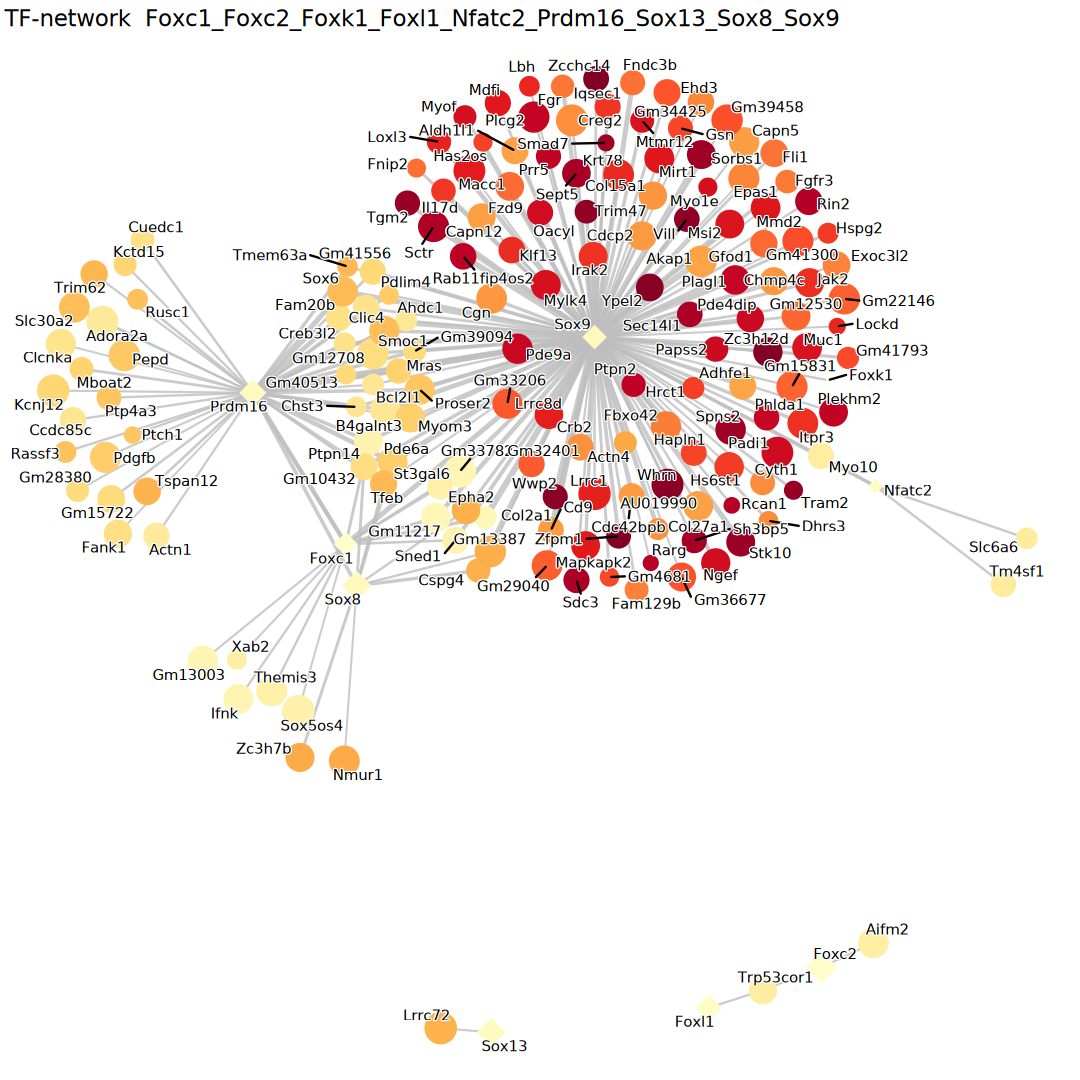

In [21]:
# module5
options(repr.plot.width=9, repr.plot.height=9)
set.seed(101)
p1= g %>% as_tbl_graph() %>% activate(nodes) %>% mutate(degree  = centrality_degree()) %>% 
      ggraph(layout='nicely') + geom_edge_link(aes(edge_width=links$corr), alpha=.8, colour='grey') + scale_edge_width_continuous(range = c(0.4,1.5)) +
      geom_node_point(aes(size = size), shape=expre$TF, color = cols_f(vcount(g)),show.legend = F) + scale_size(range=c(1, 8) * 1.1) + scale_color_manual(values = cols_f(ecount(g)))+ 
      geom_node_text(aes(label= name), repel=TRUE, size = 3, bg.color = "white") + 
      ggtitle(paste('TF-network ',paste(names(tflist),collapse = '_'  )) ) + theme_void()+ theme(legend.position = 'none') + theme_void()+theme(legend.position = 'none') + theme(legend.position = 'none')+
      coord_equal()
      #geom_edge_arc(aes(edge_width=links$corr), alpha=.8, colour='grey',strength = 0.05) 设置线条圆滑
p1
ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/GRN_module5.pdf',p1,width = 8.5, height = 8.5)

# tf trend

In [12]:
library(Seurat)
library(Signac)
library(ggplot2)
library(ComplexHeatmap)
colors <- c('#53A85F', '#F1BB72', '#F3B1A0', '#D6E7A3', '#57C3F3', '#476D87', '#E95C59', '#E59CC4')

In [33]:
fib_nonchod <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/celline/mouseskin/Mskin_fib_proce_nonchod.rds')

In [34]:
skin_fib_meta <- read.csv('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/celline/mouseskin/skin_fib_meta.csv',sep='\t',header = TRUE,row.names=1)
# 添加celltype信息并按palantir_pseudotime	排序
skin_fib_meta$celltype <- fib_nonchod@meta.data['celltype_sub']$celltype_sub
skin_fib_meta <- skin_fib_meta[order(skin_fib_meta$palantir_pseudotime),]

DORC          Motif    Enrichment.Z Enrichment.P Enrichment.log10P
1       0610040F04Rik Ahctf1    0.82481233  0.40947815    0.38776927      
2       0610040F04Rik Ahr      -1.39312314  0.16358256   -0.78626301      
3       0610040F04Rik Aire      1.58951223  0.11194480    0.95099609      
4       0610040F04Rik Alx1      1.32222222  0.18609416    0.73026725      
5       0610040F04Rik Alx3      0.52128594  0.60216760    0.22028262      
6       0610040F04Rik Alx4      1.32222222  0.18609416    0.73026725      
7       0610040F04Rik Ar        1.44175209  0.14937232    0.82572986      
8       0610040F04Rik Arid2     0.06451959  0.94855651    0.02293679      
9       0610040F04Rik Arid3a    0.70435604  0.48121107    0.31766439      
10      0610040F04Rik Arid3b   -0.44454477  0.65664877   -0.18266687      
11      0610040F04Rik Arid3c   -0.16053597  0.87245889   -0.05925503      
12      0610040F04Rik Arid5a    0.34729726  0.72836801    0.13764914      
13      0610040F04Rik Arid5b   -0.36302547  0.71658586   -0.14473177      
14      0610040F04Rik Arnt      0.26418913  0.79163418    0.10147546      
15      0610040F04Rik Arnt2     0.10005674  0.92029928    0.03607092      
16      0610040F04Rik Arntl     0.48149559  0.63016431    0.20054620      
17      0610040F04Rik Arx       0.59252023  0.55350228    0.25688059      
18      0610040F04Rik Ascl1     0.33861747  0.73489792    0.13377298      
19      0610040F04Rik Ascl2     0.89759245  0.36940287    0.43249974      
20      0610040F04Rik Atf1     -0.58108344  0.56118422   -0.25089455      
21      0610040F04Rik Atf2      0.64947873  0.51602899    0.28732590      
22      0610040F04Rik Atf3      0.32732223  0.74342418    0.12876332      
23      0610040F04Rik Atf4     -0.88617042  0.37552570   -0.42536033      
24      0610040F04Rik Atf6      1.17293190  0.24082312    0.61830183      
25      0610040F04Rik Atf6b     1.88042325  0.06005042    1.22148397      
26      0610040F04Rik Atf7      0.11295418  0.91006688    0.04092669      
27      0610040F04Rik Atoh1    -1.64766913  0.09942059   -1.00252369      
28      0610040F04Rik Atoh7    -0.70521647  0.48067554   -0.31814798      
29      0610040F04Rik Bach1     0.59473203  0.55202261    0.25804314      
30      0610040F04Rik Bach2    -0.21233595  0.83184495   -0.07995762      
⋮       ⋮             ⋮        ⋮            ⋮            ⋮                
1898971 Zmiz1os1      Zfp691   -1.29017090  0.196991329  -0.70555289      
1898972 Zmiz1os1      Zfp692    1.46699325  0.142377892   0.84655744      
1898973 Zmiz1os1      Zfp711    0.77911011  0.435914853   0.36059833      
1898974 Zmiz1os1      Zfp740   -0.71047029  0.477412549  -0.32110617      
1898975 Zmiz1os1      Zfp768    0.92844793  0.353175267   0.45200972      
1898976 Zmiz1os1      Zfp770    0.49736208  0.618933742   0.20835584      
1898977 Zmiz1os1      Zfp771   -0.86898898  0.384853157  -0.41470495      
1898978 Zmiz1os1      Zfp777    0.52234176  0.601432402   0.22081318      
1898979 Zmiz1os1      Zfp784   -1.94957228  0.051227120  -1.29050006      
1898980 Zmiz1os1      Zfp787   -0.91733668  0.358966243  -0.44494639      
1898981 Zmiz1os1      Zfp879   -3.14309279  0.001671728  -2.77683428      
1898982 Zmiz1os1      Zfp90     0.60222524  0.547024217   0.26199345      
1898983 Zmiz1os1      Zfp932    0.10279123  0.918128663   0.03709645      
1898984 Zmiz1os1      Zfx      -1.07379971  0.282912459  -0.54834793      
1898985 Zmiz1os1      Zic1     -0.23531532  0.813964009  -0.08939480      
1898986 Zmiz1os1      Zic2      0.80485813  0.420901552   0.37581947      
1898987 Zmiz1os1      Zic3      0.09911671  0.921045604   0.03571887      
1898988 Zmiz1os1      Zic4     -1.68392480  0.092196203  -1.03528696      
1898989 Zmiz1os1      Zic5     -0.51098416  0.609362148  -0.21512453      
1898990 Zmiz1os1      Zik1     -0.76461292  0.444502070  -0.35212621      
1898991 Zmiz1os1      Zkscan1   3.22862076  0.001243887   2.90521897      
1898992 Zmiz1os1      Zkscan17 -2

In [40]:
figR.d <- read.csv('/jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/caipengfei/workspace/multimodal/scCAT/Mouse_skin/joint/FigR/figR_drivers.csv',row.names = 1)
# 高变gene中加入figR的tf进行scale
fib_nonchod=FindVariableFeatures(fib_nonchod, nfeatures = 2000)
hvg=VariableFeatures(fib_nonchod[['RNA']])
DefaultAssay(fib_nonchod) <- 'RNA'
RNAdata = as.data.frame(scale(fib_nonchod@assays$RNA@data[c(hvg,unique(figR.d[figR.d$Score >= 2, ]$Motif)),]))

In [91]:
RNAdata = as.data.frame(scale(fib_nonchod@assays$RNA@data[c(unique(figR.d[figR.d$Score >= 2, ]$Motif)),]))

In [92]:
# 表达矩阵排序
motif_RNAdata <- t(RNAdata)[,c(figR.d[figR.d$Score >= 2, ]$Motif)]
motif_RNAdata <- motif_RNAdata[match(rownames(skin_fib_meta), rownames(motif_RNAdata)),]
motif_RNAdata <- motif_RNAdata[, !duplicated(t(motif_RNAdata))] # 去除重复列
# 合并
trends_plot <- cbind(skin_fib_meta,motif_RNAdata)

In [ ]:
'Gli1''Mef2c''Ar''Prrx2''Lhx2''Gli2''Twist2''En1''Shox2''Runx3''Runx1''Runx2''Mef2d''Zeb2''Tcf4'

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


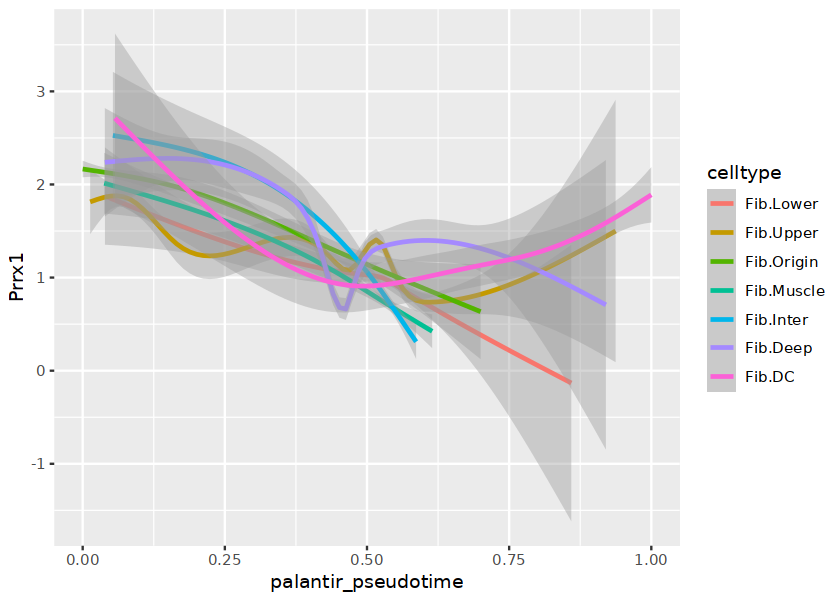

In [109]:
options(repr.plot.width = 7, repr.plot.height = 5)
ggplot(data=trends_plot, aes(x=palantir_pseudotime,y=Prrx1,color=celltype,group=celltype))+geom_smooth()

In [128]:
heatmap_plot <- t(trends_plot[,8:ncol(trends_plot)])
heatmap_plot

E13_HU2_BC0503_N04 E13_HU1_BC2874_N02 E13_HU4_BC03268_N03
Zeb2     3.6949443          3.7262853          2.98481191        
Sox9    -0.5448664         -0.4477417         -0.51786263        
Twist2   1.8337063         -0.4477417          0.93268403        
Gli1    -0.5448664         -0.4477417         -0.51786263        
Creb5    0.3563919         -0.4477417          0.17226883        
Gata6   -0.5448664         -0.4477417         -0.51786263        
Fos     -0.5448664         -0.4477417          0.99560996        
Junb    -0.5448664         -0.4477417         -0.51786263        
Nfkb2   -0.5448664         -0.4477417         -0.51786263        
Foxd1   -0.5448664         -0.4477417         -0.51786263        
Nfkb1    0.3868634         -0.4477417          0.17739371        
Zeb1    -0.5448664          1.0584765         -0.51786263        
Klf4    -0.5448664         -0.4477417         -0.51786263        
Nfatc2   0.5078528          1.1834483          0.33061640        
Foxc1   -0.5448664         -0.4477417         -0.51786263        
Plagl1   0.4103664         -0.4477417         -0.51786263        
Foxp2    1.9309157          2.2741859          1.44079703        
Prdm16  -0.5448664         -0.4477417          0.99474845        
Fosb    -0.5448664         -0.4477417         -0.51786263        
Mecom   -0.5448664          0.9619441          0.01937480        
Ebf2     1.1296058         -0.4477417         -0.51786263        
Lmx1b   -0.5448664         -0.4477417         -0.51786263        
Klf5    -0.5448664         -0.4477417         -0.51786263        
Lef1     1.4343444         -0.4477417          2.03450979        
Sox11   -0.5448664         -0.4477417         -0.11631268        
Meis2    1.1188101         -0.4477417         -0.07303095        
Relb    -0.5448664         -0.4477417         -0.51786263        
Runx2    1.1164567          3.1459657         -0.51786263        
Pparg   -0.5448664         -0.4477417         -0.51786263        
Ebf1     1.3327438         -0.4477417         -0.51786263        
⋮       ⋮                  ⋮                  ⋮                  
Cdx4    -0.5448664         -0.4477417         -0.5178626         
Obox6   -0.5448664         -0.4477417         -0.5178626         
Ppard    1.1538391         -0.4477417          0.3718188         
Tbx6    -0.5448664         -0.4477417         -0.5178626         
Zfp384  -0.5448664         -0.4477417         -0.5178626         
Lin54   -0.5448664         -0.4477417         -0.5178626         
Mybl1   -0.5448664         -0.4477417         -0.5178626         
Rbpj     0.3852410         -0.4477417          0.1266886         
Arnt2    0.4623824         -0.4477417          1.0260153         
Lhx6    -0.5448664         -0.4477417         -0.5178626         
Prrx2   -0.5448664         -0.4477417         -0.5178626         
Tgif2   -0.5448664          1.1160821         -0.5178626         
Tcf21   -0.5448664         -0.4477417         -0.5178626         
Foxh1   -0.5448664         -0.4477417         -0.5178626         
Zic5    -0.5448664         -0.4477417         -0.5178626         
Ar      -0.5448664         -0.4477417         -0.5178626         
Atf1    -0.5448664         -0.4477417         -0.5178626         
Zfp42   -0.5448664         -0.4477417         -0.5178626         
Jun      0.4214769         -0.4477417         -0.5178626         
Tead1    1.1559491          1.6146691          2.9076202         
Spic    -0.5448664         -0.4477417         -0.5178626         
Sp3      2.3279550          1.9298450          0.1031990         
Foxa2   -0.5448664         -0.4477417         -0.5178626         
Onecut1 -0.5448664         -0.4477417         -0.5178626         
Trps1    2.7624858          1.7598634          2.4571192         
Arid5b   2.8890405          2.3523462          2.6654144         
Foxl1   -0.5448664         -0.4477417         -0.5178626         
Zfp423  -0.5448664         -0.4477417         -0.5178626         
Tbx4    -0.5448664         -0.4477417         -0

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 9)
BluYl = colorRampPalette(colors = c("blue","yellow"))(100)
p2 = pheatmap(heatmap_plot,cluster_rows = F, cluster_cols = F, show_rownames = F, #scale = "row",
               breaks = seq(-2, 2, length = 101), color = hcl.colors(100, "BluYl"),
               show_colnames = F, use_raster=TRUE,
               main='Chromatin accessibility')
p2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



# Fib.DC (DORCs)

In [1]:
library(FigR)
library(ComplexHeatmap)
library(scCustomize)
library(JASPAR2020)
library(Signac)
library(Seurat)
library(TFBSTools)
library(BSgenome.Mmusculus.UCSC.mm10)
library(patchwork)
library(cowplot)
set.seed(1234)

Loading required package: Matrix

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats,

## Fib.DC谱系

最优参数DORCs(n≥5)，score.cut=2

In [5]:
fib.DC <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/scCAT/Mskin_fib_DC.rds')

In [7]:
table(fib.DC$orig.ident)


 E13_HU1  E13_HU2  E13_HU3  E13_HU4  E13_HU5 E14_HU11 E14_HU12 E14_HU13 
      69       41       37       32       24      493      460      462 
E14_HU14 E14_HU15 E15_HV21 E15_HV22 E15_HV23 E15_HV24 E15_HV25 E16_HU16 
     463      421      948      881      797     1015     1435      136 
E16_HU17 E16_HU18 E16_HU19 E16_HU20  E18_HX1  E18_HX2 
     135      147      185      142     1069     1155 

In [5]:
ATAC.se = SummarizedExperiment(assays = list(counts=fib.DC@assays$ATAC@counts),rowRanges = fib.DC@assays$ATAC@ranges,colData = fib.DC@meta.data)
RNAmat = fib.DC@assays$RNA@counts

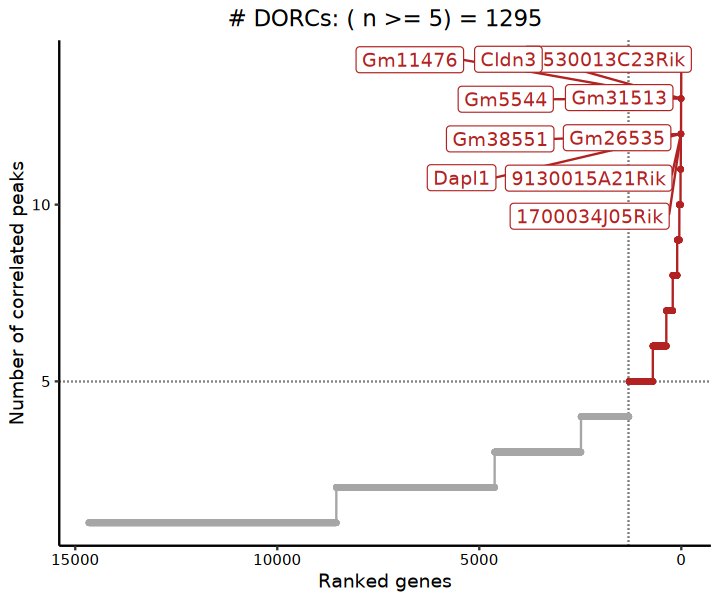

In [4]:
# FigR results
cisCorr <- read.csv('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/scCAT/Mskin_fib_DC_trac_cisCorr.csv',row.names = 1)
cisCorr.filt <- cisCorr %>% filter(pvalZ <= 0.05)
options(repr.plot.width=6, repr.plot.height=5)
dorcGenes <- dorcJPlot(dorcTab = cisCorr.filt, cutoff = 5, labelTop = 10, cleanLabels=TRUE, returnGeneList = TRUE, force=20)

In [6]:
topic_fibDC

In [ ]:
## DORC calling and smooth ##
library(FNN)
library(cisTopic)
library("foreach")
dorcMat <- getDORCScores(ATAC.se = ATAC.se, dorcTab = cisCorr.filt, geneList = dorcGenes, nCores = 4)
# cistopic数据导入
topic_fibDC <- read.csv('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/03_MouseSkin/fibroblast/fib_DC_topic.csv')
topic_fibDC <- topic_fibDC[,-1]
# Search Nearest Neighbors
cellkNN_fibDC <- get.knn(t(topic_fibDC),k = 5)$nn.index
rownames(cellkNN_fibDC) <- colnames(topic_fibDC)
# data smooth
dorcMat.s <- smoothScoresNN(NNmat = cellkNN_fibDC,mat = dorcMat,nCores = 4)
RNAmat.s <- smoothScoresNN(NNmat = cellkNN_fibDC,mat = RNAmat,nCores = 4)
saveRDS(dorcMat.s,'/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_DC_dorcmat_s.rds')
saveRDS(RNAmat.s,'/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_DC_rnamat_s.rds')

In [4]:
figR.d <- read.csv('scCAT_seq/03_MouseSkin/fib.DC/Mskin_fib_DC_figR_n5.csv',row.names = 1)
figR.filt <- figR.d[figR.d$Score > 2, ]
figR.filt
# write.csv(figR.filt, file = '/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/scCAT/Mskin_fib_DC_figR_n5_score2.csv', quote = F)

DORC          Motif  Enrichment.Z Enrichment.P Enrichment.log10P
7933    1700024I08Rik Lef1   2.964626     3.030516e-03 2.518483         
14487   1700036A12Rik Fos    5.089206     3.595661e-07 6.444221         
14488   1700036A12Rik Fosb   4.544649     5.502698e-06 5.259424         
14490   1700036A12Rik Fosl2  5.000578     5.715866e-07 6.242918         
14652   1700036A12Rik Junb   3.194399     1.401223e-03 2.853493         
14763   1700036A12Rik Nfkb1  3.604782     3.124152e-04 3.505268         
14893   1700036A12Rik Relb   3.768013     1.645518e-04 3.783697         
16537   1700042O10Rik Plagl1 3.097734     1.950065e-03 2.709951         
18264   1700057H21Rik Rela   3.534996     4.077820e-04 3.389572         
21231   1700113B09Rik Fos    4.366592     1.262004e-05 4.898939         
21232   1700113B09Rik Fosb   4.519128     6.209483e-06 5.206945         
21507   1700113B09Rik Nfkb1  2.827145     4.696512e-03 2.328225         
23086   2010320O07Rik Klf1   2.999022     2.708476e-03 2.567275         
27132   2610037D02Rik Fos    2.993170     2.760961e-03 2.558940         
27133   2610037D02Rik Fosb   3.105957     1.896640e-03 2.722015         
33829   4833412C05Rik Ebf1   3.145659     1.657129e-03 2.780644         
37799   4930401G09Rik Trp63  2.746837     6.017311e-03 2.220598         
40896   4930465M20Rik Nfkb1  2.835147     4.580462e-03 2.339091         
43149   4930523C07Rik Fos    4.303554     1.680802e-05 4.774483         
43152   4930523C07Rik Fosl2  4.324584     1.528200e-05 4.815820         
43425   4930523C07Rik Nfkb1  3.118522     1.817608e-03 2.740500         
54109   4930595D18Rik Fosb   2.995054     2.743966e-03 2.561621         
54384   4930595D18Rik Nfkb1  3.165804     1.546550e-03 2.810636         
59016   4933424G06Rik Alx4   2.941340     3.267961e-03 2.485723         
62814   5430401H09Rik Nfkb1  4.563710     5.025750e-06 5.298799         
65068   5430425K12Rik Fosb   3.095200     1.966803e-03 2.706239         
65343   5430425K12Rik Nfkb1  4.290592     1.781971e-05 4.749099         
65863   5830428M24Rik Ebf1   3.554114     3.792553e-04 3.421068         
65910   5830428M24Rik Fos    3.820892     1.329696e-04 3.876248         
66186   5830428M24Rik Nfkb1  3.309855     9.334438e-04 3.029912         
⋮       ⋮             ⋮      ⋮            ⋮            ⋮                
1034517 Trim25        Fos    4.348403     1.371323e-05 4.862860         
1034520 Trim25        Fosl2  4.963186     6.934613e-07 6.158978         
1036156 Trim47        Ebf1   4.423937     9.691826e-06 5.013594         
1039612 Triobp        Foxp2  2.629176     8.559214e-03 2.067566         
1041011 Trmo          Zeb1   4.776834     1.780764e-06 5.749394         
1041262 Trp73         Fosb   3.776474     1.590642e-04 3.798428         
1044586 Tspan4        Ebf1   3.651724     2.604853e-04 3.584217         
1044666 Tspan4        Foxo3  3.009171     2.619614e-03 2.581763         
1045085 Tspan4        Sox13  3.162123     1.566233e-03 2.805144         
1049130 Ttll10        Nhlh2  2.765194     5.688902e-03 2.244972         
1049691 Ttyh2         Fos    3.304512     9.514194e-04 3.021628         
1049692 Ttyh2         Fosb   3.751294     1.759245e-04 3.754674         
1049967 Ttyh2         Nfkb1  4.886016     1.028968e-06 5.987598         
1061446 Vsir          Ebf1   3.124239     1.782655e-03 2.748933         
1063179 Wdfy2         Fos    3.065379     2.173944e-03 2.662752         
1063180 Wdfy2         Fosb   3.026243     2.476132e-03 2.606226         
1063455 Wdfy2         Nfkb1  2.773376     5.547802e-03 2.255879         
1076304 Zc3h12d       Spib   4.722402     2.330757e-06 5.632503         
1076861 Zc3h3         Lhx4   2.869641     4.109375e-03 2.386224         
1077360 Zcchc14       Alx4   3.073676     2.114392e-03 2.674814         
1080040 Zfand3        Fosb   5.307446     1.111720e-07 6.954005         
1080315 Zfand3        Nfkb1  5.157175     2.507041e-07 6.600839         
1083411 Zfp36         Fos    4.590960     4.412121e-06 5.355353   

In [10]:
# figR.filt <- figR.d[figR.d$Score > 0.8, ]
# figR.runx2 <- figR.filt[figR.filt$Motif=='Runx2',]
# write.csv(figR.runx2, file = 'scCAT_seq/03_MouseSkin/fib.DC/Mskin_fib_DC_figR_runx2.csv', quote = F)

Using absolute score cut-off of: 2 ..


Using Score as value column: use value.var to override.

Plotting 395 DORCs x 125TFs




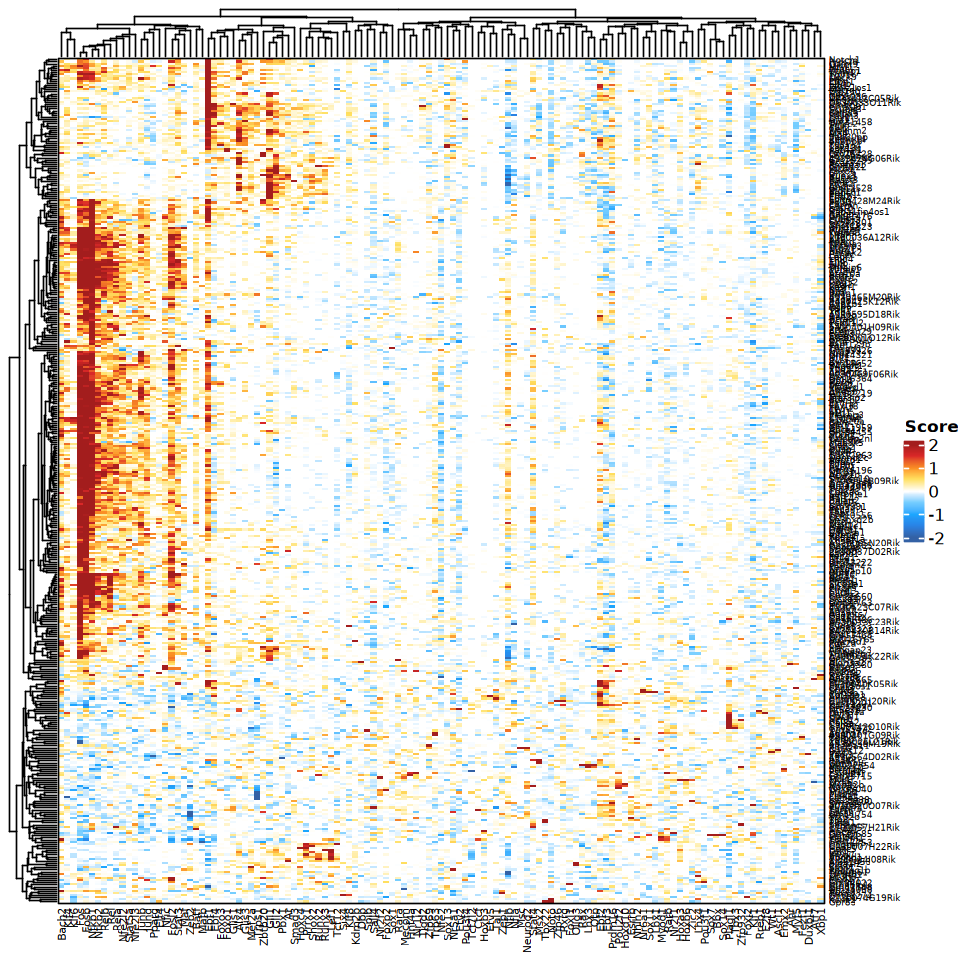

In [55]:
options(repr.plot.width=8, repr.plot.height=8)
res.h <- plotfigRHeatmap(figR.d = figR.d,score.cut = 2,column_names_gp = gpar(fontsize=6),show_row_dend = TRUE)
draw(res.h,heatmap_legend_side = "right",gap = unit(0, "cm"))
# pdf('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_DC_heatmap_cut5.pdf',width = 8,height = 8)
# res.h
# dev.off()
require(ggplotify)
g = as.ggplot(res.h)
# ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_DC_heatmap_cut5.pdf',g,width = 8,height = 8)

In [56]:
# 行列重新排序
res.h.mat <- res.h@matrix
set.seed(123);row_idx <- row_order(res.h)
set.seed(123);col_idx <- column_order(res.h)
rowid_dorc_list <- rownames(res.h.mat)[row_idx]
colid_tf_list <- colnames(res.h.mat)[col_idx]
regMat <- res.h.mat[row_idx,col_idx]
regMat

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”


Bach2         Klf4        Klf6         Fos          Fosb       
Notch1         0.075046516  0.304058666  0.000000000  0.997872598  1.52176878
Prss23         0.697578385  0.000000000  0.000000000  1.163027117  0.97230278
Galnt9         0.170596560  0.515078744  0.342796940  1.137066081  1.30644484
Mrvi1          0.905440944  0.661048075  1.080864134  2.068191165  1.39102359
Mlph           0.097990232  0.532053517  0.977070994  1.155065320  1.40513686
Dtnbp1         1.476519360  1.769222273  0.438449193  0.232160162  1.11668328
Trim47         0.614334669  0.959723666  0.571519926  1.650585119  1.44503005
Tgif1          0.974060545  0.000000000  0.000000000  2.003103265  1.93294935
Dock9          0.000000000  0.230356183  0.023202798  1.015394613  1.63867985
Fgr            0.228726664  0.260930962  0.373956695  1.918331504  1.75041411
Ptpn1          0.231491121  0.364534372  0.000000000  1.195435164  0.78987041
Eif4b          0.249115951  0.027792953  0.000000000  0.961155402  0.02860991
Jag1           0.470700981  0.085336952  0.020371305  0.542875809  0.64275759
Zmiz1os1       0.558926364  0.491342711  0.005259667  1.745145597  0.16794799
Metrnl        -0.589586461  0.007096025 -0.009782630  0.522647284  0.99071354
Zfp750         0.000000000  0.852552271  0.101994588  0.091702049  0.13656465
Heyl           0.009636361  0.192081352  0.000000000  0.000000000  0.00000000
Gm5086         0.000000000  0.035225575  0.000000000  0.000000000  0.00000000
4833412C05Rik  0.030707689  0.250472755  0.000000000  0.480368529  0.45633147
Htr1d          0.000000000  0.026150403  0.015026521  0.284620679 -0.52069628
D630033O11Rik  0.219592474  0.000000000  0.153751707  0.086984293  0.12405702
Smoc1          0.085354465  0.010023754  0.067656338  0.407681630  0.32633059
Gm5091         0.000000000  0.019025127  0.000000000  0.020974464  0.01709070
Scube3         0.000000000  0.419599620  0.000000000  0.204914795  0.26275058
Lamc3          0.000000000  0.513678426  0.000000000  0.000000000  0.00000000
Gdpd5          0.000000000  0.492316962  0.048113471  0.206278774  0.15211435
Pdlim3         0.000000000  0.928017355  0.011938228  0.000000000  0.04981131
Lnx1           0.449242749  0.000000000  0.068925595 -0.328615478 -0.38693708
Gja1           0.023323581  0.058017123  0.860872944  0.000000000  0.12136230
Gm31458        0.000000000  0.300301750  0.065042664  0.004077638  0.20396926
⋮             ⋮             ⋮           ⋮            ⋮            ⋮          
Tcte1          2.0117137092 -0.07936284 -0.20734622  -0.935558243 -1.40082426
Gm17753        0.7547138249 -0.01279104 -0.50712548  -0.102908243 -0.15378116
C1qtnf7        0.0000000000 -0.09308378  0.00000000  -0.200424697 -0.27068240
C030007H22Rik  0.0023161812  0.00000000  0.00000000   0.000000000  0.00000000
Hoxc5          0.0000000000  0.00000000 -0.17325310   0.000000000  0.00000000
Lef1           0.3406233046  0.00000000  0.00000000  -0.214064510 -0.25171667
Ism1           0.0000000000  0.00000000  0.00000000   0.000000000  0.00000000
Bmp7           0.0004763277  0.00000000 -0.26715438   0.000000000  0.00000000
Apcdd1         0.6763726529  0.00000000 -0.27300877   0.000000000  0.00000000
1700024I08Rik  0.3349548764 -0.04498451  0.00000000  -0.079657549 -0.03282524
AI661453       0.0049845025  0.00000000  0.00000000  -0.147052302 -0.29034352
Sipa1l2        0.4634981800  0.02402211  0.00000000   0.030168799 -0.07711984
Cckbr          0.0517589889 -0.22785280  0.00000000  -0.223084583 -0.20350387
Ston1          0.0602749335  0.04624685  0.00000000  -0.349204747  0.76619570
Ppargc1b       0.0654082073  0.11234207  0.00000000  -0.787935455 -0.40781019
Tmem61         0.0525766732  0.00000000  0.00000000   0.117885346  0.18042078
Dmrtb1         1.0404796121  0.00000000  0.25466214   0.186779956 -0.02764315
Zc3h3          0.0000000000 -0.14449750  0.18083445   0.000000000  0.00000000
Mbd2           0.0672037937  0.05283654  0.12074122   0.646150989  0.18524738
Crybb1        -0.5704402669 -0.10265

In [57]:
gene_all <- unique(c(rownames(regMat),colnames(regMat)))

---
### GRN

In [19]:
module2 <- sliceModule(regMat, row_sel = c('Notch1','Lpin2'), col_sel = c('Ebf1','Lef1'))

In [20]:
module2

$matSlice
                     Ebf1        Ebf4       Foxo3         Foxo1        Glis1
Notch1         2.33965266  0.88168749  0.51947046  3.390416e-01  0.000000000
Prss23         2.91533136  0.17547965  0.19849884  1.714939e-02  0.000000000
Galnt9         2.04097891  0.28788406  0.66287896  1.375234e-01  0.000000000
Mrvi1          7.30820311  0.28083349  0.01740793  0.000000e+00  0.221798963
Mlph           5.46769617  0.53773854  0.11748894  0.000000e+00  0.000000000
Dtnbp1         6.02933413  0.15149439  0.02958527  0.000000e+00  0.311684735
Trim47         5.01358990  1.36638260  0.77921872  7.823269e-01  0.000000000
Tgif1          5.03465582  1.16013071  0.11516167  0.000000e+00  0.010701240
Dock9          3.26471005  0.42977916  0.62424238  9.041943e-01  0.000000000
Fgr            5.04247442  1.18742245  0.04170972  0.000000e+00  0.464041367
Ptpn1          3.26203654  0.13816811  0.00000000  9.349824e-02  0.260068363
Eif4b          2.60511858  0.68328949  0.07172644  3.079340e-01  0.183088420
Jag1           3.28133085  0.02932964  0.75531334  3.297658e-02  0.203161938
Zmiz1os1       2.57579452  1.30361513  0.51668235  9.303153e-01  0.000000000
Metrnl         3.12395250  0.40424063  0.00000000  5.868382e-05 -0.076458485
Zfp750         3.04499662  0.22026422  0.00000000  0.000000e+00  0.348126725
Heyl           5.49000404  0.59743149  0.32311493  1.409024e-01  0.000000000
Gm5086         3.67409462  1.00953222  0.05094032  4.406277e-01  0.000000000
4833412C05Rik  2.70807194  0.16428657  0.11210610  0.000000e+00  0.000000000
Htr1d          3.45666671  0.18526780  0.00000000  0.000000e+00  0.124013209
D630033O11Rik  2.55972753  0.18744506  0.03743710  3.401887e-01  0.000000000
Smoc1          2.39907137  2.39950228  0.34254712  5.106068e-01  2.831941525
Gm5091         2.62289197  2.45427732  1.33039427  2.989874e-01  0.880078798
Scube3         2.05784111  1.86687006  0.64272493  4.525200e-01  0.000000000
Lamc3          3.30945776  1.12197285  0.88025561  4.638033e-01  0.071786118
Gdpd5          5.40169440  2.26727750  0.37619166  9.187558e-02  0.000000000
Pdlim3         3.39599797  3.12023461  0.50842672  4.898871e-01  0.000000000
Lnx1           2.25918015  1.68644988  0.01533977 -1.944035e-01  0.040459425
Gja1           1.64897156  0.42089944  0.00000000  2.181640e-01  0.445606734
Gm31458        2.59605298  0.43811267  0.34176910  3.119296e-02  0.204424913
Tmcc2          2.76243098  0.54131129  1.66783858  6.099384e-01  0.060310851
Vsir           2.58562979  1.70434564  0.22463625  4.375377e-01  0.653340863
Cerk           3.26730359  0.06733504  0.03767832  7.067705e-01  0.567747419
Plekhm2        2.91859472  0.63837601  0.18229557  2.294641e-01  0.605282582
Alx4           1.79888573  1.33232290  0.46719086  9.789118e-02  0.000000000
Mgll           2.06996299  0.35676413  0.03670571  0.000000e+00  0.000000000
Sap30bp        2.75194420  0.86280232  0.39949543  3.822336e-01  0.000000000
Zcchc14        1.48162369  1.07693064  0.60475979  5.103093e-01  0.053227672
Sh3bp5         3.37629170  0.58945927  0.09827824  0.000000e+00  0.870581845
Pgs1           2.67597672  0.65447947  0.99806057  3.438966e-01  0.041609717
Tspan4         2.49775224  0.39909138  2.15753423  7.070857e-01  0.362636715
Sox13          1.60644663  0.30424601 -0.19389539  3.661060e-01  0.000000000
Katnal1        1.96034221  0.73233236  0.70106972  2.073267e+00  0.712300523
Fermt2         0.66509055  0.43968432  0.24045742  2.147152e+00  0.053579080
Gm26728        0.60027472  0.24040282  0.00000000  0.000000e+00  0.000000000
Foxo6os       -0.21744926 -0.14842396  0.10099348  4.987757e-02  0.000000000
4933424G06Rik  0.06981759  0.99305283  1.02176049  1.641682e-01  0.998203081
Gm16299        0.91551346  0.29379652  0.82746383 -3.470401e-01  0.102671109
Bcar3          0.82904239  0.08392809  0.38830638  2.242278e-01  0.000000000
Pmepa1        -0.20773577 -0.22157958  0.18676800  3.536041e-03  0.039752250
Gm5122         0.00000000  0.00000000  0.00000000  8.820513e-02

In [94]:
#DORC的部分motif不全，gene score作为染色质可及性分数也不全
# 给cisCorr.filt加上过滤掉的gene, 
add_gene1 <- c(setdiff(dorcGenes,unique(cisCorr.filt$Gene)))
add_gene <- intersect(add_gene,cisCorr$Gene)
none_gene <- add_gene1[!(add_gene1 %in% add_gene)]
dorcGenes <- dorcGenes[!(dorcGenes %in% none_gene)]
# 从cisCorr提出相应行并加到cisCorr.filt上
add_ciscorr = list()
for (i in add_gene) {
    add_ciscorr[[i]] = cisCorr[cisCorr$Gene == i, ]
    }
add_ciscorr <- do.call(rbind, lapply(add_gene, function(i) cisCorr[cisCorr$Gene == i,]))
ciscorr.modified <- rbind(cisCorr.filt,add_ciscorr)
rownames(ciscorr.modified) <- NULL
dorcMat <- getDORCScores(ATAC.se = ATAC.se, dorcTab = ciscorr.modified, geneList = dorcGenes, nCores = 4)

Running DORC scoring for 1391 genes: A530013C23Rik, Cldn3, Gm11476, Gm31513, Gm5544, 1700034J05Rik, 9130015A21Rik, Dapl1, Gm26535, Gm38551, Grb2, 1700029H14Rik, Cd44, Gm15179, Gm36660, Il1r1, Ppargc1b, Rin3, 1700001L19Rik, 1700041M19Rik, ... , ... , ... (truncated display)



........
Normalizing scATAC counts ..
SummarizedExperiment object input detected .. Centering counts under assayCentering counts for cells sequentially in groups of size  5000  ..

Computing centered counts for cells:  1  to  5000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  5001  to  10000 ..
Computing centered counts per cell using mean reads in features ..

Computing centered counts for cells:  10001  to  10547 ..
Computing centered counts per cell using mean reads in features ..

Merging results..
Done!
Computing DORC scores ..
Running in parallel using  4 cores ..

Time Elapsed:  2.48250333865484 mins 



In [95]:
module_use = module2

In [96]:
######################################## 获取用于
# figR.d处理，score大于2，且在module中的motif，获得motif对应DORC的列表
net.dat <- figR.d %>% filter(Score >= 2)
net.dat <- net.dat %>% filter(Motif %in% module_use$col_slice)
net.dat$Motif <- paste0(net.dat$Motif)
net.dat$DORC <- paste0(net.dat$DORC)
tflist.tab <- split(x = net.dat, f = net.dat$Motif)
tflist <- lapply(tflist.tab, FUN = function(x){ x$DORC  } )
#
dorcs <- data.frame(name = unique(net.dat$DORC), group = "DORC", size = 3)
tfs <- data.frame(name = unique(net.dat$Motif), group = "TF", size = 8)
nodes <- rbind(dorcs, tfs)
nodes$isinHeatmap <- ifelse(nodes$name %in% module_use$row_slice,'yes','no')
nodes$name <- paste0(nodes$name)
idx <- which(duplicated(nodes$name))
nodes$name[idx] <- paste0( nodes$name[idx],'_',nodes$group[idx]  )
edges <- as.data.frame(net.dat)
# 去除数字的gene
cut <- dorcs[grep("Rik$", dorcs$name),]$name
nodes = nodes[!(nodes$name %in% cut),]
edges = edges[!(edges$DORC %in% cut),]
# link处理
links <- data.frame(
        source = unlist(lapply(edges$Motif, function(x) { which(nodes$name == x) })),
        target = unlist(lapply(edges$DORC, function(x) { which(nodes$name == x) })),
        corr = edges$Corr, 
        enrichment = edges$Enrichment.P
    )
links$Value <- scales::rescale(edges$Score) * 20
links$source_name <- as.character(nodes$name[links$source])
links$target_name <- as.character(nodes$name[links$target])
links <- links[order(links$source_name, links$target_name), ] # 排序
links

source target corr       enrichment   Value       source_name target_name
3    3      3     0.10168734 1.246869e-03  3.39086672 Alx4        Alx4       
9    3      8     0.06600615 5.157103e-03  1.07927110 Alx4        Bcar3      
25   3     23     0.08269547 2.611029e-03  2.16938254 Alx4        Gdpd5      
32   3     27     0.07295465 2.339279e-03  2.33130724 Alx4        Gm13528    
34   3     28     0.03924324 4.532202e-05  3.28138485 Alx4        Gm16299    
35   3     29     0.03668119 4.279302e-03  0.21384534 Alx4        Gm26728    
68   3     54     0.06687939 1.508574e-03  2.99667401 Alx4        Plekhm2    
71   3     55     0.03583753 7.876973e-04  1.81782729 Alx4        Pmepa1     
77   3     61     0.05001724 8.062915e-03  0.04123443 Alx4        Ptgfrn     
84   3     67     0.04931352 7.569053e-04  0.00000000 Alx4        Runx1      
86   3     68     0.08342379 2.321995e-03  2.37232299 Alx4        Runx3      
93   3     72     0.03953455 1.065836e-04  1.78992231 Alx4        Sh3bp5     
107  3     82     0.08409943 2.114392e-03  2.53843287 Alx4        Zcchc14    
2   90      2     0.03985625 1.000116e-03  1.47940208 Ar          AI661453   
87  90     68     0.06153898 8.128727e-04  1.67551579 Ar          Runx3      
8   86      7     0.06948690 1.158677e-03  3.52137382 Ebf1        Baiap2     
11  86     10     0.04549350 4.323531e-05  4.77213098 Ebf1        Cerk       
12  86     11     0.04199122 1.678114e-05  1.86162399 Ebf1        Cyb5r3     
13  86     12     0.04784424 2.888857e-04  4.76235742 Ebf1        Dock9      
14  86     13     0.07886161 7.867498e-07 15.18066481 Ebf1        Dtnbp1     
16  86     15     0.06186387 2.478885e-03  2.27672954 Ebf1        Eif4b      
17  86     16     0.11605802 5.683107e-03  0.92120661 Ebf1        Fam20a     
19  86     18     0.07977226 8.959643e-06 11.46174770 Ebf1        Fgr        
24  86     22     0.07560552 9.046735e-03  0.15080559 Ebf1        Galnt9     
26  86     23     0.09372576 1.745352e-06 12.81544499 Ebf1        Gdpd5      
29  86     24     0.06598368 1.999745e-05  9.59313964 Ebf1        Gipc2      
31  86     26     0.06636825 2.087092e-04  5.59271392 Ebf1        Gm11476    
37  86     30     0.04427960 8.441888e-04  2.24256638 Ebf1        Gm31458    
39  86     31     0.07337521 2.116850e-04  6.30509673 Ebf1        Gm5086     
40  86     32     0.05857222 2.069653e-03  2.34370739 Ebf1        Gm5091     
⋮   ⋮      ⋮      ⋮          ⋮            ⋮           ⋮           ⋮          
33   89    27     0.06361554 2.717730e-05 4.472053860 Gli1        Gm13528    
50   89    39     0.03473487 1.655227e-03 0.869582188 Gli1        Katnal1    
55   89    43     0.03428607 2.217670e-03 0.154152703 Gli1        Lpin2      
65   89    51     0.06489293 6.640379e-03 0.046266446 Gli1        Pdlim3     
70   89    54     0.05721080 8.333637e-03 0.088765431 Gli1        Plekhm2    
72   89    56     0.04971761 5.747755e-05 4.612516534 Gli1        Prdm1      
76   89    60     0.07685865 6.622827e-05 8.058663068 Gli1        Ptch2      
78   89    61     0.05262270 8.810668e-04 2.849276126 Gli1        Ptgfrn     
85   89    67     0.05670954 4.311931e-03 0.710400230 Gli1        Runx1      
88   89    68     0.06376510 2.820293e-03 1.262400268 Gli1        Runx3      
6    25     5     0.05613603 8.219616e-03 0.245230483 Gli2        Arhgap23   
22   25    20     0.06170559 1.640160e-04 2.091835618 Gli2        Foxo6      
30   25    25     0.05910192 2.071029e-03 2.494294145 Gli2        Gli2       
75   25    59     0.06100700 1.199969e-03 3.208595704 Gli2        Ptch1      
97  101    73     0.05818232 9.302910e-04 3.131497151 Glis1       Smoc1      
38   97    30     0.03884196 6.443420e-04 0.438002597 Glis3       Gm31458    
44   99    35     0.03716913 2.470317e-03 0.170975049 Hoxc4       Hoxc5      
5    41     4     0.05088207 4.929136e-03 0.655394800 Lef1        Apcdd1     
47   41    37     0.05969463 9.039528e-03 0.139799247 Lef1        Ism1       
52   41    41     0.065583

In [97]:
# 创建igraph对象
g_links <- links[,c('source_name', 'target_name', 'corr')] # TF \ DORCs \ corr
g <- graph_from_data_frame(g_links)
# gene used
vtx <- igraph::V(g)
gene.use <- unique(names(vtx))
n_pathvtx <- length(unique(links$source_name))

In [99]:
#### 表达信息和染色质可及性信息 ####
# skin.fib <- readRDS('/hwfssz5/ST_SUPERCELLS/P21Z10200N0090/caipengfei/workspace/temp/scCAT/Skin_fibroblast.rds')
# dorcMat <- readRDS('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/Mskin_fib_dorcmat_modified.rds')
# DORC
dorcmat <- as.data.frame(dorcMat)[gene.use,]
# data.frame(DORC = log2(rowSums(dorcmat)+1))
DORCexpre <- data.frame(DORC = log2(rowMeans(dorcmat)+1))
# RNA
RNAmat = as.data.frame(scale(fib.DC@assays$RNA@data[gene.use,]))
RNAmat[is.na(RNAmat)] <- 0 # 去除na
RNAexpre <- data.frame(RNA = rowMeans(RNAmat))
# combine
expre <- cbind(DORCexpre,RNAexpre)
expre[,"TF"] <- 16
expre[1:n_pathvtx,"TF"] <- 18
expre

DORC      RNA          TF
Alx4     2.7594740 -0.267841233 18
Ar       1.4400543 -0.106538480 18
Ebf1     3.1063383  2.160281549 18
Ebf4     0.6233912 -0.237853484 18
Foxo1    0.7339174 -0.091527280 18
Foxo3    2.0728220  0.075298675 18
Gli1     3.9665261  0.080198960 18
Gli2     4.7097561  0.956205185 18
Glis1    2.1647835  0.151453297 18
Glis3    0.2236808  0.034183817 18
Hoxc4    1.3734954 -0.125708131 18
Lef1     3.2674663  0.682888656 18
Mef2a    0.4996828  0.834174281 18
Prrx1    3.3126070  1.261445077 18
Runx2    1.1525484  0.256179739 18
Runx3    4.3258168 -0.150565387 18
Smad3    4.1362606  0.128135737 18
Zbtb20   0.5597281  1.096434500 18
Bcar3    2.4828281 -0.107219320 16
Gdpd5    1.5546357 -0.196315564 16
Gm13528  2.9519217 -0.303757527 16
Gm16299  2.5353853 -0.324020064 16
Gm26728  2.2086923 -0.304605799 16
Plekhm2  2.7151378 -0.122316563 16
Pmepa1   2.7593975  0.055276055 16
Ptgfrn   2.7738474  0.397631185 16
Runx1    4.8195072  0.597158471 16
Sh3bp5   1.2051536 -0.186182531 16
Zcchc14  2.2209881 -0.005912355 16
AI661453 2.6240360 -0.264048956 16
⋮        ⋮         ⋮            ⋮ 
Smoc1    0.8820347 -0.12524699  16
Synj2    2.6301771 -0.17122802  16
Tcp11l2  3.9507386 -0.20455157  16
Tgif1    4.1592479 -0.13761157  16
Tmcc2    2.3667442 -0.23698667  16
Trim47   2.8155172 -0.29506726  16
Tspan4   2.1934580 -0.26818983  16
Vsir     2.3655287 -0.30258080  16
Zfp750   2.2184454 -0.18154071  16
Zmiz1os1 2.2761487 -0.11435146  16
Fermt2   2.6629965  0.23536196  16
Katnal1  1.6890763 -0.22501354  16
Ahdc1    3.0504305  0.10079755  16
Bahcc1   4.9047890  0.09068287  16
Ehd2     3.5471499  0.06478406  16
Foxo6    4.0892547 -0.29716554  16
Lpin2    2.1401519  0.03215163  16
Prdm1    2.4707000 -0.13299582  16
Ptch2    4.4524283  0.03093216  16
Arhgap23 4.8441040  0.19423107  16
Ptch1    4.2340674  0.89616005  16
Hoxc5    5.2395837  0.24356012  16
Apcdd1   3.3038098  0.69405514  16
Ism1     2.7818899 -0.07911986  16
Ston1    3.5672944 -0.05351680  16
Bmp7     4.5527403  0.07386027  16
Gm5122   3.6176124 -0.32548825  16
Flnb     3.3582725  0.50733867  16
Foxo6os  2.2505983 -0.32747319  16
Plec     5.4667173  0.80887843  16

In [100]:
###### 修改节点 ######
# gene expression 节点颜色
range(expre$RNA) #-0.215450614377099  5.80248130151223
color1 = colorRampPalette(colors = c("#5567B1","#B3D5F1","#F8FFEC"))(20)
color2 = colorRampPalette(colors = c("#F8FFEC","#F0686C"))(20) # 100渐变色
x1 <- as.numeric(cut(expre$RNA, breaks = seq(-0.5, 0, length.out = 20)))
x2 <- as.numeric(cut(expre$RNA, breaks = seq(0, 2, length.out = 20)))
# 根据区块将对应的值贴上颜色
palette1 <- color1[x1]
palette2 <- color2[x2]
palette <- c()
for (i in seq_along(palette1)) {
  if (is.na(palette1[i])) {
    palette[i] <- palette2[i]
  } else {
    palette[i] <- palette1[i]
  }
}
# palette[which(rownames(expre) %in% c("Tcf4","Fgfr2","Zeb2","Agap1"))] <- "#F0686C"  # 将超出的部分定为最红
V(g)$color <- palette # 存入
# DORC accessibility 节点大小
range(expre$DORC)
map <- function(data, MIN, MAX) {
  d_min <- max(data)
  d_max <- min(data)
  return(MIN + (MAX - MIN) / (d_max - d_min) * (data - d_min))
}
DORCsize <- map(expre$DORC,1,10) * 1.1
V(g)$size <- DORCsize
###### 修改edge ######
#E(g)$weight <- links$corr/3 # 添加相关性信息

[1] -0.3275574  2.1602815

[1] 0.2236808 5.4667173

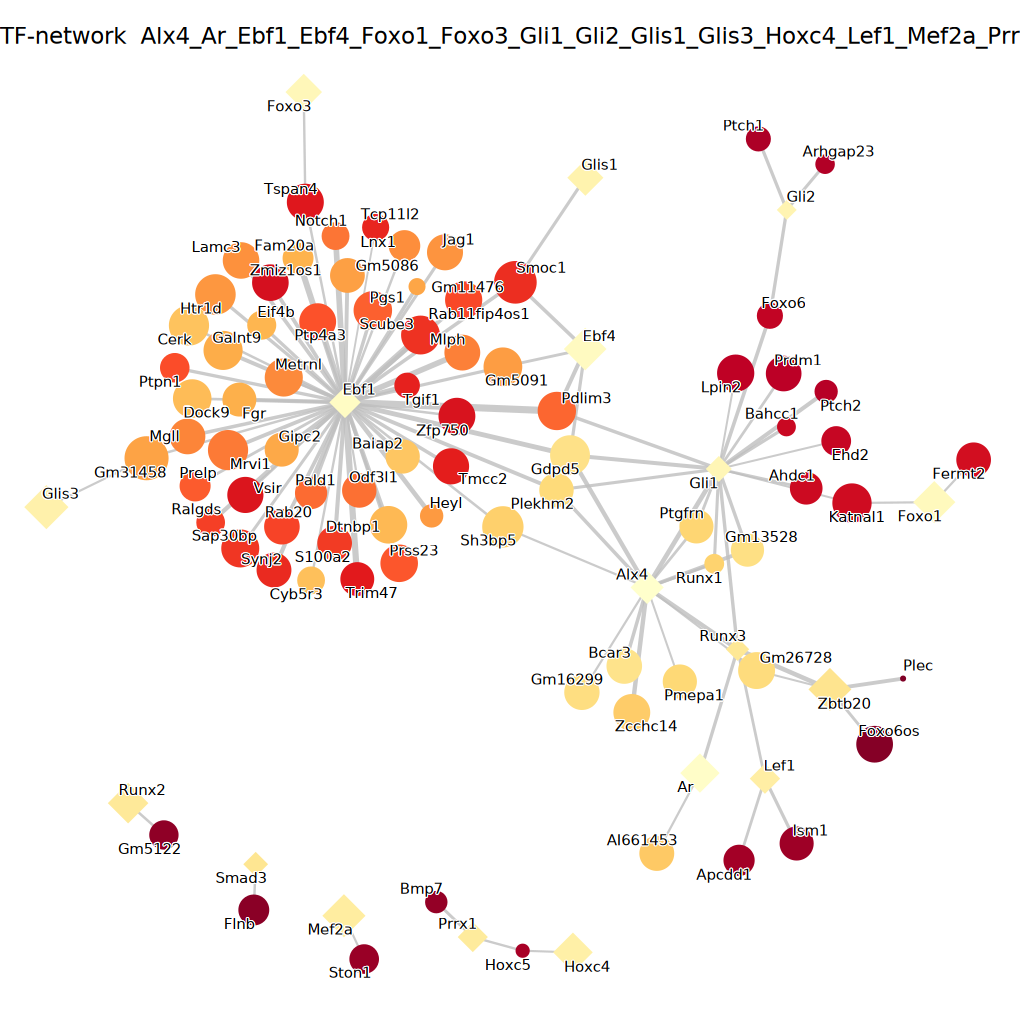

In [112]:
# plot with igraph
set.seed(101)
cols_f <- colorRampPalette(RColorBrewer::brewer.pal(9, 'YlOrRd'))
# module1
options(repr.plot.width=8.5, repr.plot.height=8.5)
set.seed(101)
p1= g %>% as_tbl_graph() %>% activate(nodes) %>% mutate(degree  = centrality_degree()) %>% 
      ggraph(layout='nicely') + geom_edge_link(aes(edge_width=links$corr), alpha=.8, colour='grey') + scale_edge_width_continuous(range = c(0.4,1.5)) +
      geom_node_point(aes(size = size), shape=expre$TF, color = cols_f(vcount(g)),show.legend = F) + scale_size(range=c(1, 11) * 1.1) + scale_color_manual(values = cols_f(ecount(g)))+ 
      geom_node_text(aes(label= name), repel=TRUE, size = 3, bg.color = "white") + 
      ggtitle(paste('TF-network ',paste(names(tflist),collapse = '_'  )) ) + theme_void()+ theme(legend.position = 'none') + theme_void()+theme(legend.position = 'none') + theme(legend.position = 'none')+
      coord_equal() 
      #geom_edge_arc(aes(edge_width=links$corr), alpha=.8, colour='grey',strength = 0.05) 设置线条圆滑
p1
# ggsave('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/fib.DC_GRN_module.pdf',p1,width = 9, height = 9)

### celloracle的TF扰动

In [26]:
TF_DC_Origin <- read.csv('/hwfssz1/ST_SUPERCELLS/P21Z10200N0090/zhangzhongjin/scCAT_seq/04_DORCs/scCAT/TF_DC_Origin.csv',row.names=1)

In [27]:
TF_DC_Origin

gene   Fib.DC      Fib.Origin
0   Ebf1   2.1337170   2.8914772 
1   Egr1   1.6548904   3.0036493 
2   Fos    1.5302939   2.7234385 
3   Klf5   1.5194710   2.9636381 
4   Klf4   1.4949644   2.6223842 
5   Nfkb1  1.4370007   2.5299740 
6   Junb   1.4232967   1.7096038 
7   Glis3  1.4123810   2.7209556 
8   Atf3   1.4107277   2.8306276 
9   Stat3  1.3065054   0.4856510 
10  Nfkb2  1.2922989   2.6283555 
11  Jun    1.2749075   1.0659446 
12  Klf9   1.2340367   2.2100310 
13  Prdm1  1.2310880   2.4663681 
14  Fosb   1.1790060   2.1882901 
15  Gli1   1.1361574   2.3456961 
16  Maf    1.1317917   2.9521600 
17  Egr3   1.0949430   1.1376180 
18  Bach2  1.0937505   2.9007962 
19  Runx3  1.0872455   0.3977628 
20  Rel    1.0537990   1.6540053 
21  Klf10  1.0445279   2.4236973 
22  Klf3   1.0433025   2.7661422 
23  Alx4   1.0094145   0.5298829 
24  Fosl2  1.0093077   0.2581009 
25  Glis1  1.0010588   1.6718607 
26  Prrx1  0.9402960   0.1131615 
27  Rela   0.9381823   1.8726499 
28  Klf12  0.8959225   1.6275919 
29  Hoxc5  0.8906143   2.6578138 
⋮   ⋮      ⋮           ⋮         
151 Cdx2   0.001427844 0.09700771
152 Eomes  0.001305216 0.10462130
153 Hoxb8  0.000452723 2.23621156
154 Ppara  0.000335247 1.60066897
155 Mef2b  0.000099100 0.01483275
156 Foxa2  0.000084700 0.87953984
157 Meox1  0.000030100 0.40118876
158 Twist1 0.000000000 0.08041282
159 Zic3   0.000000000 0.18310040
160 Zbtb18 0.000000000 0.20112298
161 Atf1   0.000000000 0.27710733
162 En1    0.000000000 0.14014841
163 Twist2 0.000000000 0.48093759
164 Rfx4   0.000000000 1.88879022
165 Tgif2  0.000000000 0.47070274
166 Tfdp1  0.000000000 1.30834814
167 Foxp2  0.000000000 0.52717899
168 Gli2   0.000000000 0.34397406
169 Hlf    0.000000000 1.31262250
170 Tcf12  0.000000000 0.88427758
171 Mecom  0.000000000 2.24979671
172 Meis2  0.000000000 1.05543076
173 Sp3    0.000000000 0.64183795
174 Sox6   0.000000000 0.99186822
175 Osr1   0.000000000 0.72136515
176 Pax2   0.000000000 1.51218252
177 Sim1   0.000000000 0.06772955
178 Pax8   0.000000000 2.06588795
179 Plagl1 0.000000000 3.07066131
180 Hoxa9  0.000000000 2.22490840

In [30]:
TF <- c('Stat3','Jun','Runx3','Fosl2','Alx4','Prrx1','Nfatc1','Runx2','Meis1','Sox2','Zic4','Prrx2','Ar','Ebf1','Gli1','Gli2','Glis1','Glis3','Lef1')    

In [29]:
intersect(TF,TF_DC_Origin$gene)

[1] "Stat3"  "Jun"    "Runx3"  "Fosl2"  "Alx4"   "Prrx1"  "Nfatc1" "Runx2" 
 [9] "Meis1"  "Sox2"   "Zic4"   "Prrx2"  "Ar"     "Ebf1"   "Gli1"   "Gli2"  
[17] "Glis1"  "Glis3"  "Lef1"

In [32]:
# 定义标记基因
TF_DC_Origin$type = ifelse(TF_DC_Origin$gene %in% TF,'mark','other')

In [51]:
TF_DC_Origin$size = ifelse(TF_DC_Origin$gene %in% TF,'0.9','0.8')

Warning message:
“Using size for a discrete variable is not advised.”


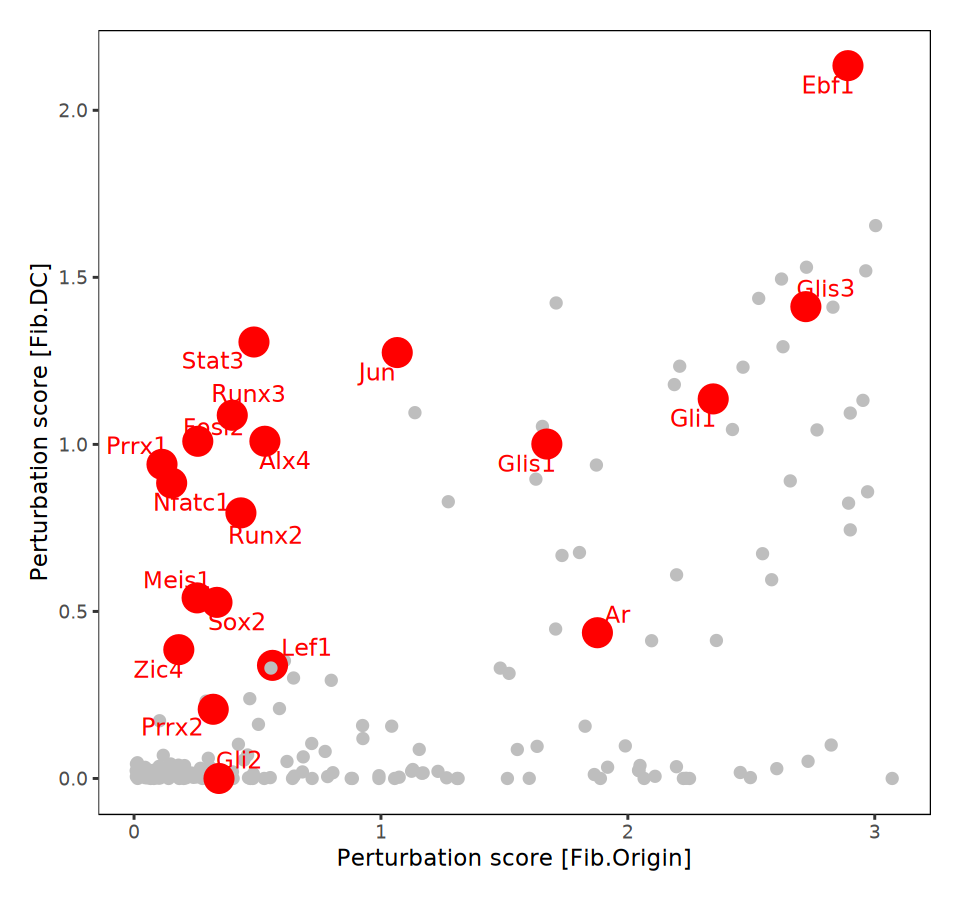

In [52]:
options(repr.plot.height = 6, repr.plot.width = 6.4)
ggplot(TF_DC_Origin, aes(x = Fib.Origin, y = Fib.DC, color = type)) + geom_point(aes(size = size)) + 
  scale_color_manual(values = c("mark" = "red", "other" = "grey")) + labs(x = "Perturbation score [Fib.Origin]", y = "Perturbation score [Fib.DC]") +
  theme(legend.position = 'none', panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_rect(color="black", fill = NA,size=.25),plot.title = element_text(size = 15, face = "bold"), plot.margin = unit(c(1,1,1,1), "lines"))+
  geom_text_repel(data=TF_DC_Origin[TF_DC_Origin$type=='mark',], aes(label= TF_DC_Origin[TF_DC_Origin$type=='mark',]$gene))

  #xlim(-1, 25) + ylim(-1, 25)

In [35]:
library(ggrepel)

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 6.4)
data <- data.frame(
  gene = seu_bulk[,0],
  x = seu_bulk[,1],
  y = seu_bulk[,2],
  type = ifelse(rownames(seu_bulk) %in% rownames(up20), "up20", ifelse(rownames(seu_bulk) %in% rownames(down20), "down20", "other"))
)
up = subset(data, type %in% c("up20"))
down = subset(data, type %in% c("down20"))
p1=ggplot(data, aes(x = x, y = y, color = type)) +
  geom_point(size = 0.6) + scale_color_manual(values = c("up20" = "red", "down20" = "blue", "other" = "black")) +
  xlim(-1, 25) + ylim(-1, 25) + labs(x = "Pseudobulk average gene expression of skin at early", y = "Pseudobulk average gene expression of skin at later") +
  theme(legend.position = 'none', panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_rect(color="black", fill = NA,size=.25),
        plot.title = element_text(size = 15, face = "bold"), plot.margin = unit(c(1,1,1,1), "lines"))+
  geom_text_repel(data=up, aes(label= rownames(up)),  nudge_x = 20-up$x, nudge_y =1.3 * (up$y-9), color = 'black',force=1) +
  geom_text_repel(data=down, aes(label= rownames(down)),max.overlaps = 25, nudge_x = down$x-8, nudge_y =19-down$y, color = 'black',force=1)+
  geom_abline(intercept = 1.5, slope = 1, color = "grey", linetype = "longdash", size = 0.8) +
  geom_abline(intercept = -1.5, slope = 1, color = "grey", linetype = "longdash", size = 0.8)
p1